<div style="padding:2%;background-color: silver;height: 100px; color: white; border-radius: 5px;">
    <h1>Just enough Data Science and Machine Learning</h1>
    <h2>Essential tools and techniques</h2>
</div>

# Chapter 5 - Data Science Topics

## Install Python libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip3 install numpy pandas scikit-learn scipy seaborn keras gensim networkx powerlaw sklearn-crfsuite

## Import libraries

In [2]:
import os
import sys
import math
import string
import operator
import pickle
import urllib.request

import numpy as np
import random as rd
from itertools import chain
import pandas as pd
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

stopwords.words('english')

nltk.download('conll2002')
nltk.download('vader_lexicon')

import networkx as nx 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score, roc_auc_score, roc_curve, auc, make_scorer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import sklearn_crfsuite
from sklearn_crfsuite import scorers

from gensim.models import KeyedVectors

import scipy.stats
from scipy import spatial
from scipy.integrate import odeint

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import PercentFormatter

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\mgikh\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mgikh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Plot settings

In [3]:
%matplotlib inline

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (14, 14),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

xxlarge = 16
xlarge = 16
large = 12

plt.rcParams.update(params)
plt.rcParams['font.size'] = '26'

# Plot style
sns.set()
sns.set_style("white")

## Helper functions

In [4]:
def getEvaluationReport(expected_y, predicted_y):
    f1_report = classification_report(expected_y, predicted_y, target_names=['1','2'])
    micro_f1 = precision_recall_fscore_support(expected_y, predicted_y, average='micro')
    macro_f1 = precision_recall_fscore_support(expected_y, predicted_y, average='macro')
    print(f1_report)
    print("micro avg", micro_f1[0], micro_f1[1])
    
def getConfusionMatrix(test_y, pred_y):
    # plotting graph for confusion matrix
    cm = confusion_matrix(test_y, pred_y)
    
    plt.figure(figsize=(5,5))
    
    sns.heatmap(cm, annot=True, cbar=False, linewidths=2, xticklabels = ['Negative (0)','Positive (1)'], yticklabels = ['Negative (0)','Positive (1)'], square=True, fmt="d")
    
    plt.title('confusion matrix')
    plt.xlabel('Predictive values', fontsize=16)
    plt.ylabel('Actual values', fontsize=16);


### 5.1 Searching, Ranking and Rating

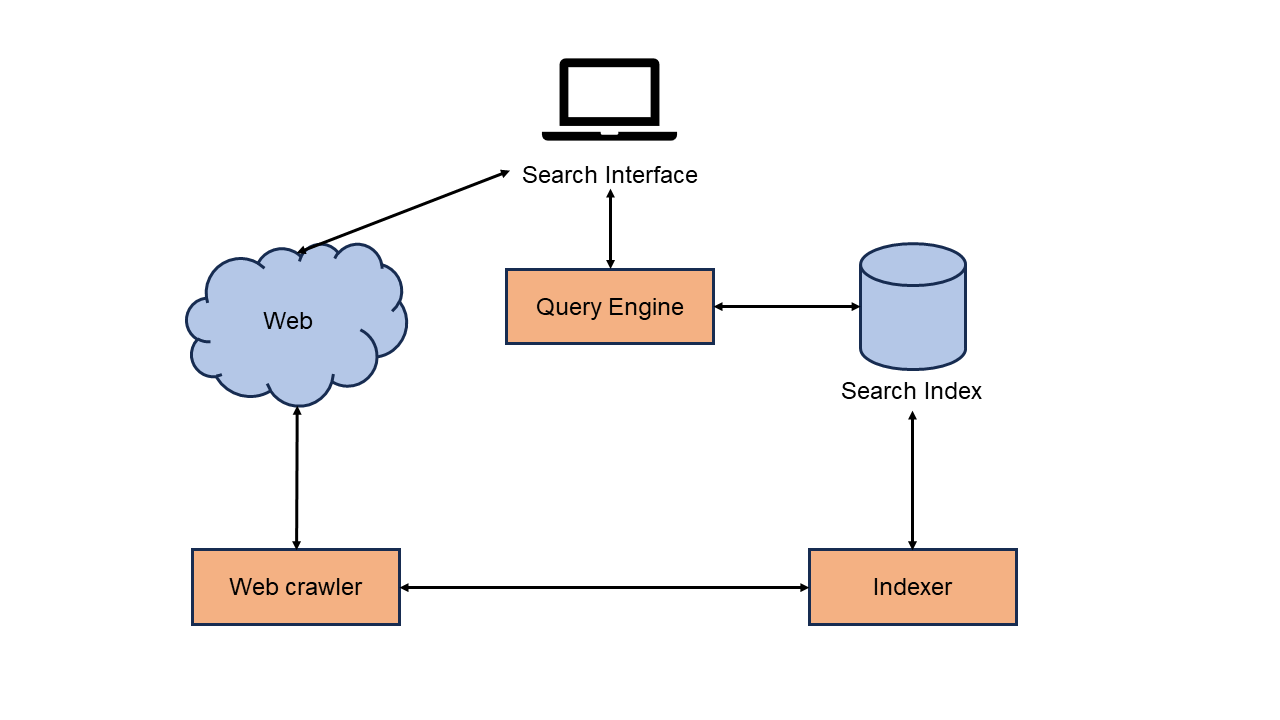

Figure 5.1: The architecture of a prototype search engine.

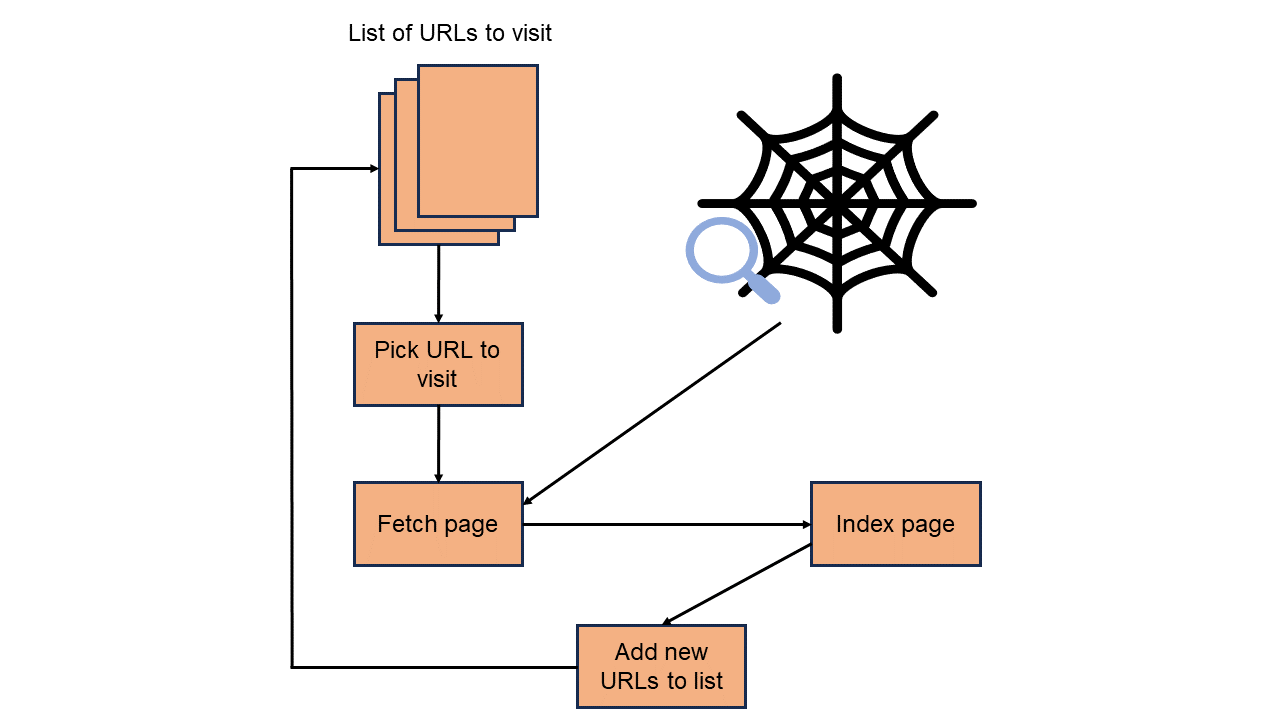

Figure 5.2: Basic crawler algorithm.

### 5.1.1 The Vector Space Model

**Example 5.1**: To illustrate TF-IDF we make use of a small corpus of BBC news articles on recent events including inflation brought about by rising energy costs, and recent military conflicts; or a sample of the data see Table 5.1. The data is composed of the text from each article, which is pre-processed into words (or tokens), and with stop words removed. The TF values of the full sample documents are shown in Table 5.2, while the IDF values are shown in Table 5.3, and the TF-IDF values are shown in Table 5.4.

In [5]:
document_folder = './data/text/'
corpus = os.listdir(document_folder)

documents = {}
for filename in sorted(corpus):
    f = open(document_folder + filename, 'rb')
    text = f.read().decode('utf8')
    documents[filename] = text
    f.close()

df_docs = pd.DataFrame.from_dict(documents, orient='index', columns = ["Headline text"])
print(df_docs.head())    

                                                Headline text
bbc001.txt  Bank of England warns the UK will fall into re...
bbc002.txt  China fires missiles near Taiwan after Pelosi ...
bbc003.txt  As it happened: Sunak and Truss clash over eco...
bbc004.txt  Tory leadership: I took money out of deprived ...
bbc005.txt  Bank's recession warning matters to everyone\r...


Table 5.1: Sample data composed of five BBC news articles on recent events including inflation, politics and world conflicts.

In [6]:
bagOfWords = {}
vocabulary = set()
uniqueWords = {}
numOfWords = {}
documents = {}
keys = ['inflation', 'bank', 'interest', 'tax', 'russia', 'ukraine', 'china']

for docid in df_docs.index:
    text = df_docs['Headline text'][docid]
    
    # Some simple preprocessing
    for s in string.punctuation:
        text = text.replace(s, " ")
        
    for i in "1234567890":
        text = text.replace(i, "")
        
    # Split into words (tokens)
    tokens = text.lower().replace('\r', '').replace('\n', '').split(' ')
    documents[docid] = " ".join(tokens)
    
    bagOfWords[docid] = [word for word in tokens if not word in stopwords.words()]

    # Compile lists of all vocabulary and unique words
    for word in bagOfWords[docid]:
        word = word.lstrip().rstrip()
        if word == '': continue
            
        vocabulary.add(word)
        uniqueWords[docid] = set(bagOfWords[docid])   

    # Compile word frequencies    
    numOfWords[docid] = dict.fromkeys(uniqueWords[docid], 0)
    for word in bagOfWords[docid]:
        numOfWords[docid].setdefault(word, 0)
        numOfWords[docid][word] += 1
    #print(numOfWords.keys())

allWords = []
for docId in numOfWords.keys():
    allWords.append(numOfWords[docId])
    #print(len(allWords))

In [7]:
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)    
    return tfDict

doc_tf = {}
for docid in sorted(numOfWords.keys()):     
    doc_tf[docid] = computeTF(numOfWords[docid], bagOfWords[docid])

df_tf = pd.DataFrame.from_dict(doc_tf, orient='index', 
                               columns = keys).fillna(0)
print(df_tf[keys].head().to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & inflation & bank & interest & tax & russia & ukraine & china \\
\midrule
bbc001.txt & 0.020833 & 0.034722 & 0.027778 & 0.000000 & 0.006944 & 0.006944 & 0.000000 \\
bbc005.txt & 0.010309 & 0.020619 & 0.010309 & 0.003436 & 0.003436 & 0.003436 & 0.000000 \\
bbc006.txt & 0.004773 & 0.004773 & 0.000000 & 0.000000 & 0.009547 & 0.026253 & 0.000000 \\
bbc010.txt & 0.001898 & 0.000000 & 0.000000 & 0.000000 & 0.018975 & 0.013283 & 0.017078 \\
bbc003.txt & 0.000000 & 0.015038 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}



Table 5.2: Sample of the term frequency (TF) of words in the corpus of BBC news articles. There are five news articles (BBC) identified by the document ID (DocID), with words in the vocabulary of all documents in the columns, document ids in rows (in column DocID), and the cells represent the term frequency (TF) of words given the document.

In [8]:
def computeIDF(documents):
    N = len(documents)
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            idfDict.setdefault(word, 0)
            idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict


idfs = computeIDF(allWords)

temp = []
for word in keys:
    idf = idfs.get(word, None)
    if idf != None:
        temp.append((word, idf))
df_idf = pd.DataFrame(temp).fillna(0)
#df_idf.columns = ["IDF"]
print(df_idf.head(10).to_latex())

\begin{tabular}{llr}
\toprule
 & 0 & 1 \\
\midrule
0 & inflation & 0.916291 \\
1 & bank & 0.356675 \\
2 & interest & 1.609438 \\
3 & tax & 2.302585 \\
4 & russia & 0.510826 \\
5 & ukraine & 0.356675 \\
6 & china & 1.609438 \\
\bottomrule
\end{tabular}



In [9]:
# TFIDF
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(documents.values())

feature_names = vectorizer.vocabulary_.keys()

dense = vectors.todense()
denselist = dense.tolist()

TFIDF_df = pd.DataFrame(denselist, columns=feature_names)
print(TFIDF_df.head())

       bank   of   england  warns  the   uk      will  fall  into  recession  \
0  0.000000  0.0  0.000000    0.0  0.0  0.0  0.000000   0.0   0.0        0.0   
1  0.000000  0.0  0.000000    0.0  0.0  0.0  0.000000   0.0   0.0        0.0   
2  0.000000  0.0  0.070677    0.0  0.0  0.0  0.000000   0.0   0.0        0.0   
3  0.000000  0.0  0.000000    0.0  0.0  0.0  0.000000   0.0   0.0        0.0   
4  0.036181  0.0  0.019423    0.0  0.0  0.0  0.026909   0.0   0.0        0.0   

   ...  shanghai  lockdownas  result  difficulties  domino  further  closer  \
0  ...  0.041933         0.0     0.0           0.0     0.0      0.0     0.0   
1  ...  0.000000         0.0     0.0           0.0     0.0      0.0     0.0   
2  ...  0.000000         0.0     0.0           0.0     0.0      0.0     0.0   
3  ...  0.000000         0.0     0.0           0.0     0.0      0.0     0.0   
4  ...  0.000000         0.0     0.0           0.0     0.0      0.0     0.0   

   buying  harder  isolate  
0     0.0     0

Table 5.3: A sample of the Inverse Document Frequency (IDF) of words in the corpus of BBC news articles. There are five news articles (BBC) identified by the document ID (DocID), with words in the vocabulary of all documents in the columns, document ids in rows (in column DocID), and the cells represent the Inverse Document Frequency (IDF) of words given the document.

In [10]:
def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

idfs = computeIDF(allWords)
doc_tfidf = {}
for docid in numOfWords.keys():     
    doc_tfidf[docid] = computeTFIDF(doc_tf[docid], idfs)

df_tfidf = pd.DataFrame.from_dict(doc_tfidf, orient='index', columns =keys).fillna(0)
print(df_tfidf[keys].head())

            inflation      bank  interest       tax    russia   ukraine  \
bbc001.txt   0.019089  0.012385  0.044707  0.000000  0.003547  0.002477   
bbc005.txt   0.009446  0.007354  0.016592  0.007913  0.001755  0.001226   
bbc006.txt   0.004374  0.001703  0.000000  0.000000  0.004877  0.009364   
bbc010.txt   0.001739  0.000000  0.000000  0.000000  0.009693  0.004738   
bbc003.txt   0.000000  0.005364  0.000000  0.000000  0.000000  0.000000   

               china  
bbc001.txt  0.000000  
bbc005.txt  0.000000  
bbc006.txt  0.000000  
bbc010.txt  0.027486  
bbc003.txt  0.000000  


Table 5.4: A sample of the Term Frequency-Inverse Document Frequency (TF-IDF) of words in the corpus of BBC news articles. There are five news articles (BBC) identified by the document ID (DocID), with words in the vocabulary of all documents in the columns, document ids in rows (in column DocID), and the cells represent the Term Frequency-Inverse Document Frequency (TF-IDF) of words given the document.

### 5.1.2 Ranking with PageRank

**Example 5.2**: In Figure 5.3 we show a simple web graph with five web pages.The random surfer starting at page B has four choices, so with probability of 1/4 the surfer will choose one of them, say C. Page C has only one outlink to E, so the surfer must move to that page. From E there are two outlinks, one back to C and the other to D. Thus the random surfer continues on the mission ad infinitum. But, what does the surfer do when reaching page A? This page, which does not have any outlink, is dangling. As a real world example, we use data released in 2002, as a part of Google’s programming contest. The web graph contains over 916,000 web pages with 5.1 million links. For the purpose of illustration, we use a small sample of 1299 web pages, i.e. its nodes, with the 2773 links between them, i.e. its edges; ten of the web pages from the small sample of this web graph are shown in tabular form in Table 5.5.

page rank dict_items([('2', 0.05247669186936449), ('1', 0.049580225276080844), ('3', 0.4241814287892371), ('4', 0.049580225276080844), ('5', 0.42418142878923715)]) SUM 1.0000000000000004
2 0.05248
1 0.04958
3 0.42418
4 0.04958
5 0.42418


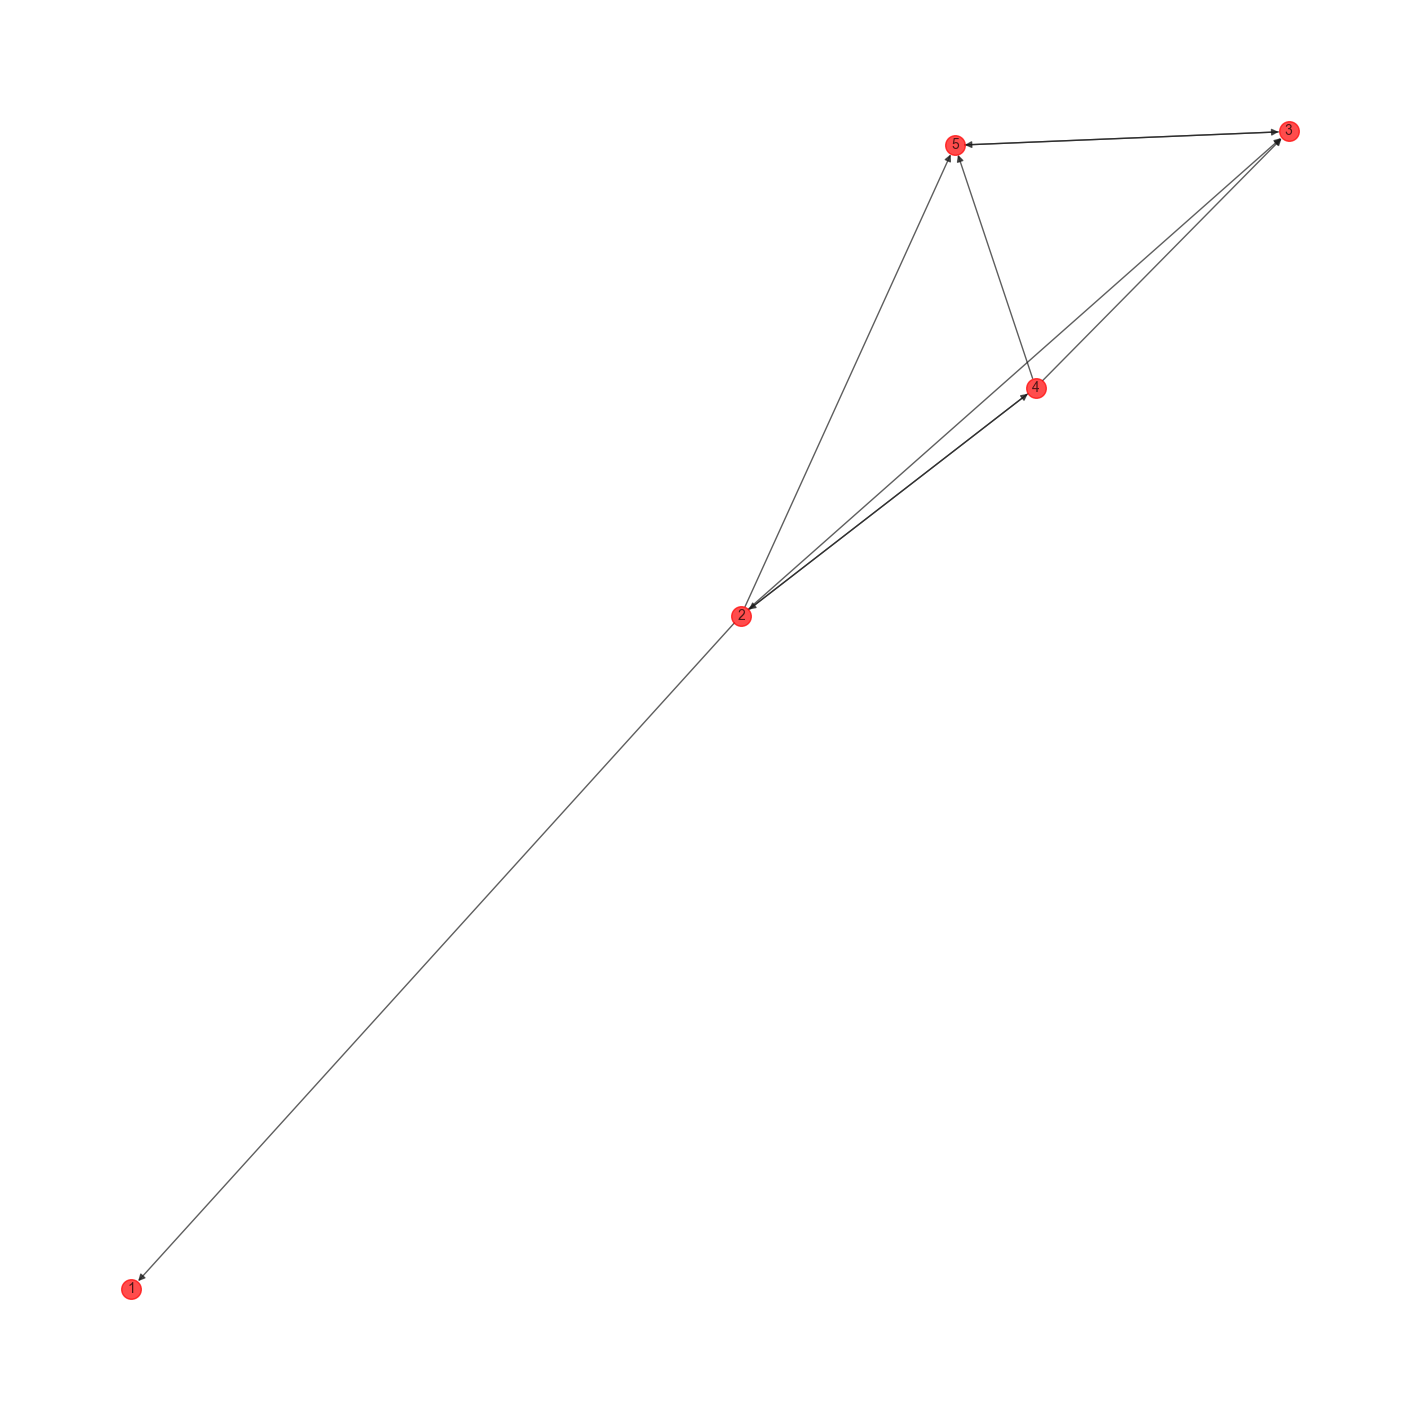

In [11]:
temp = {}
# FRom Marks web search engine graph
# Calculate and show the pagerank for the small 5 doc graph from Marks book

# Calculate the pagerank for the web example too.
G_tmp = nx.read_edgelist('./data/pagerank-mark.txt', create_using = nx.DiGraph)

# created a directed graph # LOOK AT DANGLING NODES
T = 0.15
pr = nx.pagerank(G_tmp, alpha=1-T) # Default damping factor = alpha = 0.85
print("page rank", pr.items(), "SUM", sum(pr.values()))
for p in pr.keys():

    print(p, '{:.5f}'.format(pr[p]))

#draw a graph
nx.draw(G_tmp,with_labels=True,font_color='black', alpha=0.7, arrows=None, font_size=10, node_color='red', node_size=200)

Figure 5.3: A very small web graph with five web pages, used to illustrate PageRank; the actual PageRank values are shown beside the web pages.

In [12]:
f = open('./data/web-Google.txt',"r")
temp = {}
err = 0
for row in f.readlines():
    if row[0] == '#': continue
    try:
        n1, n2 = row.replace("\n","").split("\t")
    except: 
        err += 1
        print(row)
        continue
    temp.setdefault(n2, 0)
    temp[n2] += 1
print(err)

G_tmp = nx.read_edgelist('./data/web-Google_small.txt', create_using = nx.DiGraph)

# create a directed graph based on a smaller sample.
pr = nx.pagerank(G_tmp, alpha=1-T) # Default damping factor = alpha = 0.85

table = []
for p in pr.keys():
   # if pr[p] > 0.001:
    if temp.get(p, None) == None: 
        continue
    table.append([p, temp[p], pr[p]])
        
temp = []
for r in sorted(table, key=lambda x:x[1], reverse=True)[:10]:
    nodeid, inlinks, pagerank = r
    #print((nodeid, inlinks, pagerank))
    temp.append((nodeid, inlinks, '{:.5f}'.format(pagerank)))

df = pd.DataFrame(sorted(temp, key=lambda x: x[2], reverse=True) ,columns=['Node', '#inlinks', 'PageRank'])
print(df.head(10).to_latex())

0
\begin{tabular}{llrl}
\toprule
 & Node & #inlinks & PageRank \\
\midrule
0 & 71 & 134 & 0.00161 \\
1 & 211 & 136 & 0.00070 \\
2 & 718 & 193 & 0.00052 \\
3 & 827 & 137 & 0.00047 \\
4 & 1049 & 79 & 0.00047 \\
5 & 280 & 258 & 0.00045 \\
6 & 943 & 276 & 0.00040 \\
7 & 1285 & 77 & 0.00036 \\
8 & 1068 & 71 & 0.00036 \\
9 & 1167 & 71 & 0.00036 \\
\bottomrule
\end{tabular}



Table 5.5: Ten web pages from the Google 2002 web graph small sample, in descending order of inlinks. The first column gives the node ID of the web page, the second column gives the number of its inlinks, and the final column give its PageRank.

**Example 5.3**: To illustrate the h-index we have to count of citations of every publication for an author. We can then create a citation vector by ordering the publications according to the counts of citations in descending order. 


We present h-index for two researchers, Albert Einstein (with citation statitics: min=1, mean=434, max=22202, h-index=165) and an anonymous theoretical physicist (with citation statistics: min=1, mean=166, max=3004 
h-index=63); min, mean and max denote the minimum number, mean number and maximum number of citations per paper, respectively. In Table 5. ,
we show the top-10 cited papers contained in Albert Einstein’s citation vector, where his top cited publication, which received a total of 22,2c2 citations, appears as rank 1. Figure 5.4 shows a plot of the top-100 cited pap rs
of Albert Einstein and the anonymous theoretical physicist; these plots are
called a citation curves. We note that their h-indices induce a square  nder
the citation curve, as highlighted in the fgure.

In [13]:
def h_index(citations):
    
    citations = np.array(citations)
    n         = citations.shape[0]
    array     = np.arange(1, n+1)
       
    # total number of citations for each k; k varies from 1 to n
    result    = citations >= array.reshape((-1,1))
    result    = result.sum(axis=1) 
 
    # selecting articles with least k citations for each k; 
    result    = result >= array
    
    # choosing the highest value of k
    h_idx    = array[result][-1]
        
    return h_idx


# Research 1
df = pd.read_csv('./data/h_index_Einstein.txt', names=['citations'])
citations = np.array(df['citations'].to_list())
publication = [i+1 for i in range(len(citations))]

h = h_index(citations)
print(df.head(10))

x1 = np.array(publication)#[:limit])
y1 = np.array(citations)#[:limit])

# Research 2
df = pd.read_csv('./data/h_index_Quigg.txt', names=['citations'])
citations2 = np.array(df['citations'].to_list())
publication2 = [i+1 for i in range(len(citations2))]
h2 = h_index(citations2)

x2 = np.array(publication2)
y2 = np.array(citations2)

   citations
0      22202
1      18073
2      16596
3       7034
4       6792
5       6687
6       6656
7       6614
8       6164
9       5966


Table 5.6: A sample including the top-10 cited publications contained in Albert Einstein’s citation vector.

22,202


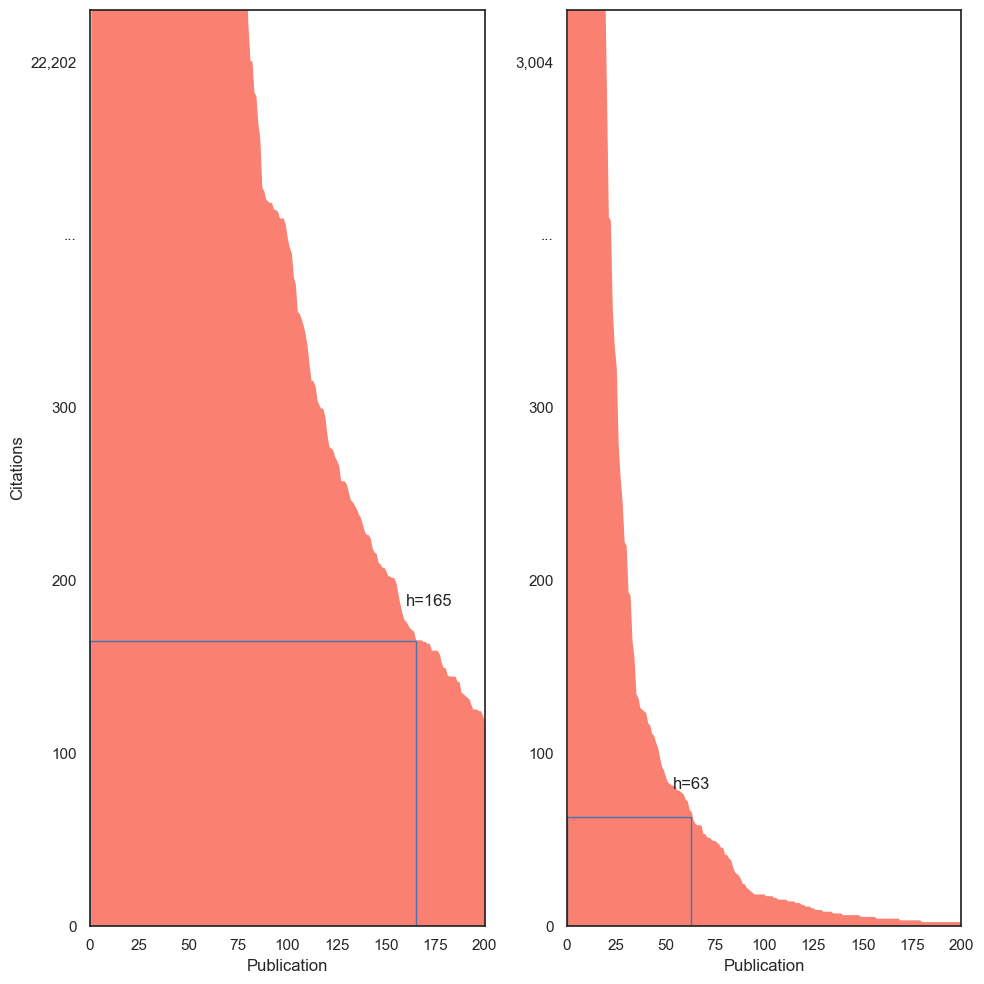

In [14]:
limit = 200

maxy = max(max(y1), max(y2)) 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10), sharey=False)

#axes[0].plot(x1, y1, color="orange", alpha=0.5)

axes[0].set_xlabel("Publication")
axes[0].set_ylabel("Citations")

#axes[1].plot(x2, y2, color="orange", alpha=0.5)

#axes[1].bar(x2, y2, color="red", alpha=0.7, width=1)
axes[1].set_xlabel("Publication")
axes[1].set_ylabel("Citations")

axes[0].set_ylim(0,530)
axes[1].set_ylim(0,530)

axes[0].set_xlim(0,limit)
axes[1].set_xlim(0,limit)

axes[0].fill_between(x1, y1, color='salmon')
axes[1].fill_between(x2, y2, color='salmon')

# Create a Rectangle patch
# Add the patch to the Axe
rect = patches.Rectangle((0, 0), h, h, linewidth=1, edgecolor='b', facecolor='none')
axes[0].add_patch(rect)

rect = patches.Rectangle((0, 0), h2, h2, linewidth=1, edgecolor='b', facecolor='none')
axes[1].add_patch(rect)

# Plot 1 label adjustment
labels = axes[0].get_yticks().tolist()
size = len(labels)
for i in range(size):
    label = labels[i]
    try:
        labels[i] = int(label)
    except:
        pass
    if i == size-3:
        label = "..."
        labels[i] = label
    if i == size-2:
        label = max(citations)
        label = f"{label:,}"
        print(label)
        labels[i] = label
axes[0].set_yticklabels(labels)

# Plot 2 label adjustment
labels2 = axes[1].get_yticks().tolist()
size = len(labels2)
for i in range(size):
    label = labels2[i]
    try:
        labels2[i] = int(label)
    except:
        pass
    if i == size-3:
        label = "..."
        labels2[i] = label
    if i == size-2:
        label = max(citations2)
        label = f"{label:,}"
        labels2[i] = label
axes[1].set_yticklabels(labels2)


axes[1].set_ylabel("")

axes[0].annotate("h="+str(h), xy=(3, 1),  xycoords='data', xytext=(0.8, 0.35), textcoords='axes fraction')
axes[1].annotate("h="+str(h2), xy=(1, 1),  xycoords='data', xytext=(0.27, 0.15), textcoords='axes fraction')

plt.tight_layout()

In [15]:
#plt.tight_layout()


Figure 5.4: A citation curve plot of the top-100 cited publications contained in Albert Einstein’s citation vector, whose h-index is 165 (left plot), and correspondingly the top-100 cited publications contained in the citation vector of an anonymous theoretical physicist whose h-index is 63 (right plot). The index of publications is shown along the x-axis, and the number of citations per publication is shown on the y-axis.

### 5.1.3 Rating with the Elo System

**Example 5.4**. The Elo rating of the top-10 ranking chess masters as of
June 2022 based is shown in Table 5.7. The Elo score of each player will
go up or down depending on how well they perform in tournaments against
other rated players. We note that a novice chess player typically has a
rating of 1200 or below, while a chess masters rating is typically 2200 or
above. The ratings of the top-10 players are far above 2500, which is the
threshold for grandmaster status. Moreover, players achieving a rating of
2700 or above are considered to be super grandmaster; the rating list as
of June 2022 contained 38 super grandmasters. The top-100 players, as of
June 2022, all had an Elo rating of greater than 2650, and 38 players had a
rating of 2700 or above.


In [16]:
df = pd.read_csv('./data/Elo_chess players.csv')
df.columns = ['Rank','Name','Nationality','Elo score']
print(df.head(10))

  Rank                       Name    Nationality  Elo score
0   #1          GM Magnus Carlsen         Norway       2864
1   #2              GM Ding Liren          China       2806
2   #3        GM Alireza Firouzja         France       2793
3   #4         GM Fabiano Caruana  United States       2783
4   #5           GM Levon Aronian  United States       2775
5   #6               GM Wesley So  United States       2773
6   #7  GM Maxime Vachier-Lagrave         France       2766
7   #8      GM Ian Nepomniachtchi        Ukraine       2766
8   #9         GM Richard Rapport        Hungary       2764
9  #10       GM Viswanathan Anand          India       2762


Table 5.7: The top-10 Elo ratings of chess players as of June 2022.

### 5.1.4 Recommender Systems and Collaborative Filtering

**Example 5.5**: We first demonstrate item-based CF on a movie data set constructed by MovieLens, consisting of 9,742 movies. The data set is represented in a item-user matrix, where each row in the data set represents an item (in this case a movie), while each column represents a user (or alternatively, a viewer); note the item-user matrix is the transpose of the rating matrix. The number in each cell is a rating between 1 and 10 given by the viewer between 1 and 10, or an empty cell when the viewer did not rate that item. In practice recommender systems often use a star system, where there are 5 stars or equivalently 10 half stars, which is identical to the 10 point rating system. A sample of the item-user matrix for five users and movies is shown in Table 5.8. Viewers only watch and rate a small subset of the full movies available, and so the full matrix of movies and user scores is very sparse, and thus there are very few scores for each movie, which may have an impact on the results of recommendation systems. The mean movie rating is derived from only those viewers who rated the movie and does not take into account movies that have no ratings. The top-5 movies watched by V1, are shown in Table 5.9.

In [17]:
import statistics, random
from sklearn.neighbors import NearestNeighbors

ratings = pd.read_csv('./data/ratings.csv', usecols=['userId','movieId','rating'])
movies = pd.read_csv('./data/movies.csv', usecols=['movieId','title'])
ratings2 = pd.merge(ratings, movies, how='inner', on='movieId')

df = ratings2.pivot_table(index='title',columns='userId',values='rating').fillna(0)
df1 = df.copy()


temp = []
all_means = []
filter = ["Sabrina (1995)", "Sudden Death (1995)", "Toy Story (1995)", "Jumanji (1995)", "Tom and Huck (1995)"]

for (k, i) in df1.iterrows():
    for f in filter:
        if f in k:
            #print(k, i)
            vals = [int(x * 2) for x in i]
            avg = statistics.mean(vals)
            temp.append([k] + vals + [avg])
            all_means.append(avg)


df2 = pd.DataFrame(temp)

df3 = df2[[0, 601, 602,603,604,605, 611]].copy()
user_labels = ['V_{a}', 'V_{2}', 'V_{3}', 'V_{4}','V_{5}']
df3.columns = ['Movie_title', 'V_{a}', 'V_{2}', 'V_{3}', 'V_{4}','V_{5}', 'Mean movie rating']

temp = []
for v in user_labels:
    temp.append(df3[v].mean())
    all_means.append(df3[v].mean())

temp.append(statistics.mean(all_means))

df3.loc[df3.shape[0]+1] = ['Mean user rating'] + temp

df3.head(6)

,Movie_title,V_{a},V_{2},V_{3},V_{4},V_{5},Mean movie rating
0,Jumanji (1995),0.0,8.0,0.0,10.0,7.0,1.237705
1,Sabrina (1995),0.0,0.0,0.0,0.0,0.0,0.563934
2,Sudden Death (1995),0.0,0.0,0.0,0.0,0.0,0.163934
3,Tom and Huck (1995),0.0,0.0,0.0,0.0,0.0,0.075410
4,Toy Story (1995),8.0,0.0,8.0,6.0,8.0,2.763934
6,Mean user rating,1.6,1.6,1.6,3.2,3.0,1.580492


Table 5.8: A sample of movies and viewer ratings per movie, with the mean
movie rating in the final column, and the mean user rating in the final row.

In [18]:
df4 = ratings2[ratings2['userId'] == 1].copy()
df4['rating'] = df4['rating'] * 2 # 5 star to 10 star conversion, due to 0.5 ratings
df4[['title', 'rating']].sample(n=5, random_state=9).sort_values('rating', ascending=False).head()

,title,rating
8313,"Quiet Man, The (1952)",10.0
5795,Dumbo (1941),10.0
16028,Big Trouble in Little China (1986),8.0
4830,Mission: Impossible (1996),6.0
9390,McHale's Navy (1997),6.0


Table 5.9: The top-5 movies watched by viewer V1, including the title and rating.

In [19]:

def recommend_movies(user, num_recommended_movies):
    recommended_movies = []
    temp = []
    for m in df[df[user] > 0].index.tolist():
    
        index_df = df.index.tolist().index(m)
        predicted_rating = df1.iloc[index_df, df1.columns.tolist().index(user)]
        
        recommended_movies.append((m, predicted_rating * 2)) # 10 star rating
    #print(recommended_movies)
    
    sorted_rm = sorted(recommended_movies, key=lambda x:x[1], reverse=True)
    
    #print('The list of the Recommended Movies \n')
    rank = 1
    
    for recommended_movie in sorted_rm:#[:num_recommended_movies]:
        temp.append(recommended_movie)
        
        #rank = rank + 1
        #if rank > 5: break

    df5 = pd.DataFrame(temp)
    
    df5.columns = ['Title', 'Score']
    return df5.sample(10, random_state=2).head().sort_values('Score', ascending=False)


df6 = recommend_movies(1, 5)
df6.head()

,Title,Score
20,"Clockwork Orange, A (1971)",10.0
30,E.T. the Extra-Terrestrial (1982),10.0
54,Henry V (1989),10.0
151,Groundhog Day (1993),8.0
208,"Last of the Mohicans, The (1992)",6.0


Table 5.10: The top-5 recommended movies for V1 based the history of movies watched by the viewer, employing KNN with k = 3.

In [20]:
#Correlation matrix
df7 = df2.loc[:, [i for i in range(603,609)]].corr().head()
df7.columns = 'V_{r1}', 'V_{r2}', 'V_{r3}', 'V_{r4}', 'V_{r5}', 'V_{r6}'
df7.head()

,V_{r1},V_{r2},V_{r3},V_{r4},V_{r5},V_{r6}
603,1.000000,0.339950,0.677908,0.612372,1.000000,0.718421
604,0.339950,1.000000,0.921819,-0.039653,0.339950,0.898408
605,0.677908,0.921819,1.000000,0.221404,0.677908,0.998398
606,0.612372,-0.039653,0.221404,1.000000,0.612372,0.256632
607,1.000000,0.339950,0.677908,0.612372,1.000000,0.718421


Table 5.11: A small sample of 11 random users Vr1 to Vr11 from the useruser correlation matrix, based on their movie rating profile. The matrix
showing how similar their movie ratings are to other users in the range of
-1 to 1.

In [21]:

def movie_recommender(user, num_neighbors, num_recommendation):
  
  number_neighbors = num_neighbors

  knn = NearestNeighbors(metric='cosine', algorithm='brute')
  knn.fit(df.values)
  distances, indices = knn.kneighbors(df.values, n_neighbors=number_neighbors)

  user_index = df.columns.tolist().index(user)

  for m,t in list(enumerate(df.index)):
    if df.iloc[m, user_index] == 0:
      sim_movies = indices[m].tolist()
      movie_distances = distances[m].tolist()
    
      if m in sim_movies:
        id_movie = sim_movies.index(m)
        sim_movies.remove(m)
        movie_distances.pop(id_movie) 

      else:
        sim_movies = sim_movies[:num_neighbors-1]
        movie_distances = movie_distances[:num_neighbors-1]
           
      movie_similarity = [1-x for x in movie_distances]
      movie_similarity_copy = movie_similarity.copy()
      nominator = 0
      
      for s in range(0, len(movie_similarity)):
        if df.iloc[sim_movies[s], user_index] == 0:
          if len(movie_similarity_copy) == (number_neighbors - 1):
            movie_similarity_copy.pop(s)
          
          else:
            movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))
            
        else:
          nominator = nominator + movie_similarity[s]*df.iloc[sim_movies[s],user_index]
          
      if len(movie_similarity_copy) > 0:
        if sum(movie_similarity_copy) > 0:
          predicted_r = nominator/sum(movie_similarity_copy)
        
        else:
          predicted_r = 0

      else:
        predicted_r = 0
        
      df1.iloc[m,user_index] = predicted_r
  recommend_movies(user,num_recommendation)

movie_recommender(1, 3, 5)

Table 5.12: Top-5 recommended movies for viewer V1, based on the movie
ratings of V1 and the user-user correlation matrix of similar users who have
rated similar movies.

## 5.2 Social Networks

### 5.2.1 The Basics of Social Networks

**Example 5.6.** To introduce social networks we consider the karate club
social network data set, captured by Wayne Zachary over a period of three
years from 1970 to 1972. The network is based on 34 individuals who were
members of a karate club. The data set records the edges (representing ties)
between pairs of members (the nodes, representing actors) in the network,
who interacted socially outside of the club. Figure 5.5 illustrates the conflict
that arose between followers of the administrator (blue nodes) and followers
of the instructor (red nodes). This conflict resulted in the division of the
club, where half of the members moved on to create a new club with the
previous instructor (red nodes), and the other group of members either found
a new club, or gave up karate completely (blue nodes).


There are 3 communities (clusters)
[8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[1, 2, 3, 7, 9, 12, 13, 17, 21]
[0, 4, 5, 6, 10, 11, 16, 19]
The average degree is 4.588235294117647


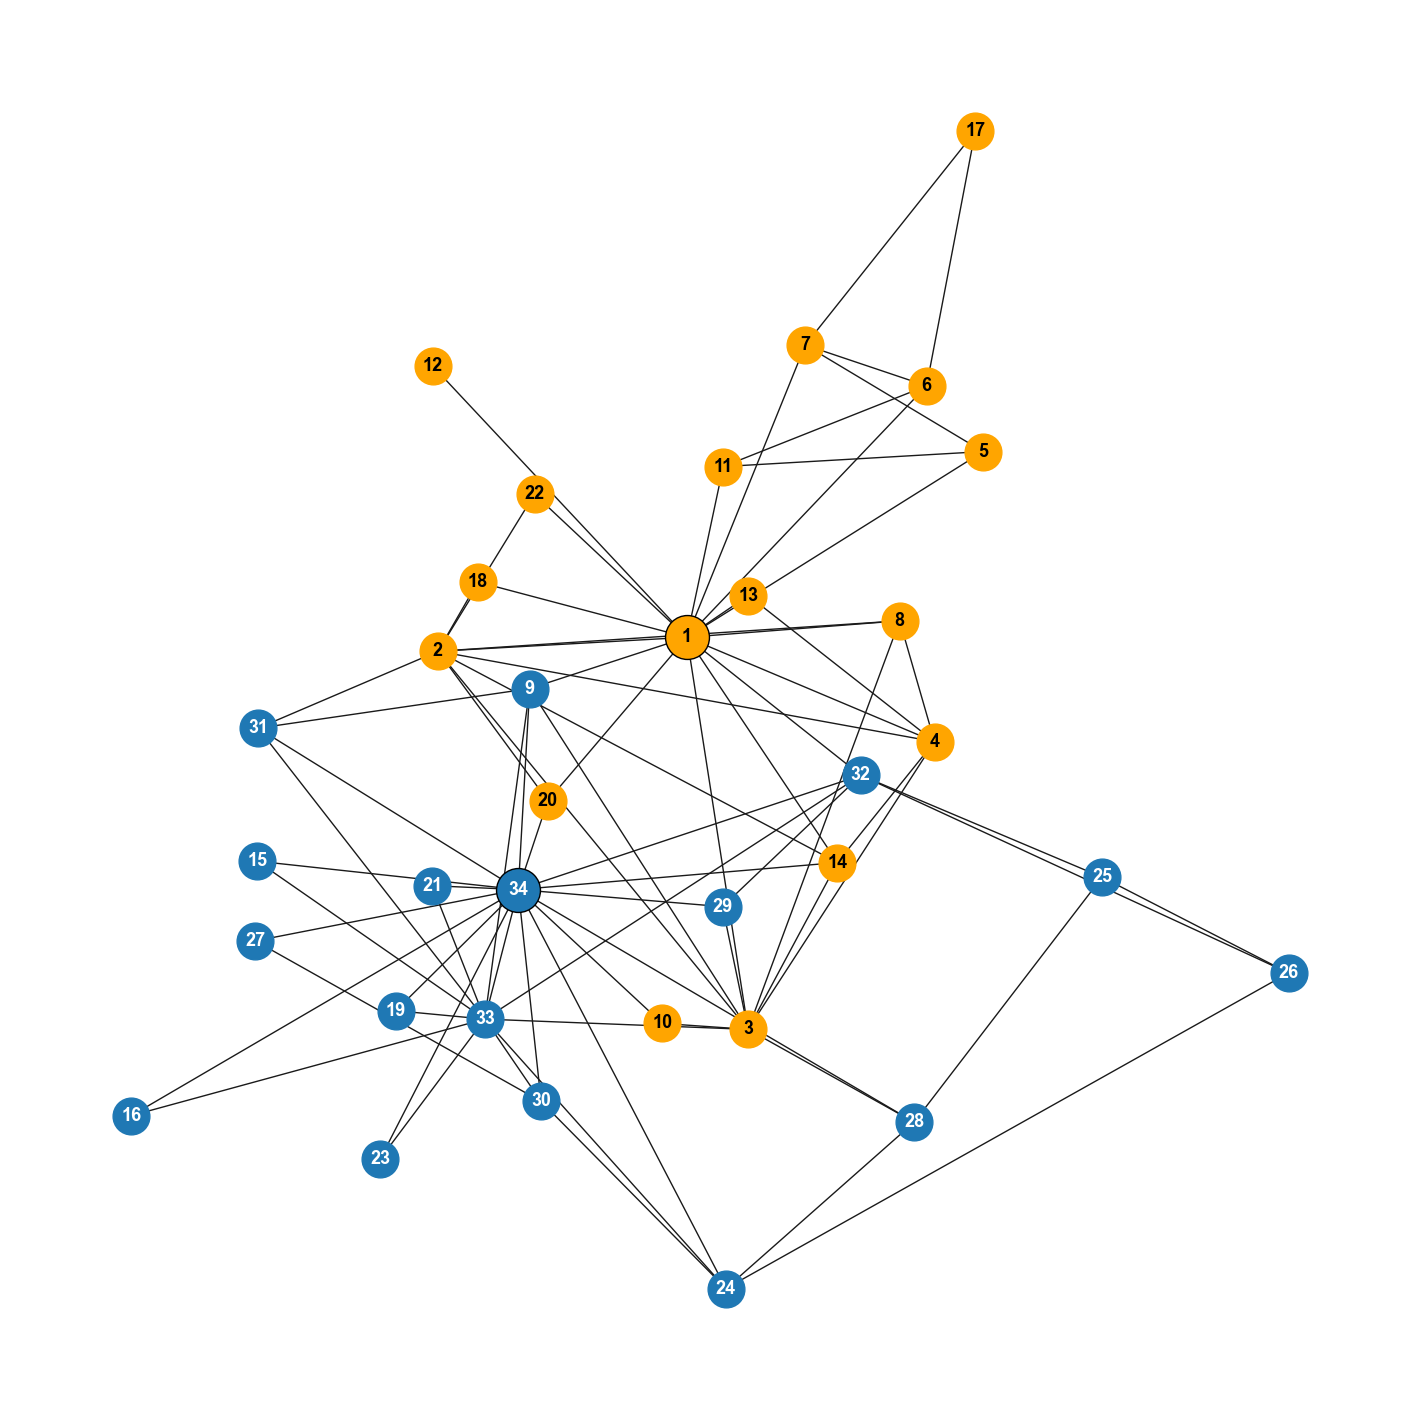

In [22]:
import sys
import networkx as nx 
import matplotlib.pyplot as plt

%matplotlib inline

#Import the ZKC graph:
G = nx.karate_club_graph()

#Keep track of which nodes represent John A and Mr Hi
Mr_Hi = 0
John_A = 33
#print(dir(nx))

#just show a couple of the labels
#print({key:club_labels[key] for key in range(10,16)})
#To plot using networkx we first need to get the positions we want for each node. 
#Here we will use a ciruclar layout but there are many other variations you could choose!
circ_pos = nx.kamada_kawai_layout(G)#circular_layout(G) 

# Use the networkx draw function to easily visualise the graph
nx.draw(G,circ_pos)

#let's highlight Mr Hi (green) and John A (red)
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

#perform the community detection

c = list(greedy_modularity_communities(G))

#Let's find out how many communities we detected
print("There are",len(c), "communities (clusters)")

#Lets see these 3 clusters
community_0 = sorted(c[0])
community_1 = sorted(c[1])
community_2 = sorted(c[2])

print(community_0)
print(community_1)
print(community_2)

#draw each set of nodes in a seperate colour

group1 = {}
for i in community_0:
    group1[i] = i + 1
    
group2 = {}
for i in community_1:
    group2[i] = i + 1

group3 = {}
for i in community_2:
    group3[i] = i +1
    
#nx.draw_networkx_nodes(G,circ_pos, nodelist=community_0, node_color='b', alpha=0.7)

temp = {}
for i in group1.keys():
    temp[i] = group1[i]
group1 = temp

temp = {}
for i in group3.keys():
    temp[i] = group3[i]
group3 = temp
  
combined_community = community_1 + community_2

grp1 = nx.draw_networkx_nodes(G,circ_pos, nodelist=community_1, node_color='orange', alpha=1, node_size=700)
grp2 = nx.draw_networkx_nodes(G,circ_pos, nodelist=community_2, node_color='orange', alpha=1, node_size=700)
grp2 = nx.draw_networkx_nodes(G,circ_pos, nodelist=community_0, alpha=1, node_size=700)

# Draw leaders.

grp1 = nx.draw_networkx_nodes(G, circ_pos, nodelist=[Mr_Hi], node_color='orange', alpha=1, node_size=1000)
grp2 = nx.draw_networkx_nodes(G, circ_pos, nodelist=[John_A], alpha=1, node_size=1000)
grp1.set_edgecolor('black')
grp2.set_edgecolor('black')



#nx.draw_networkx_labels(G, circ_pos, {Mr_Hi: 'HI'}, font_size=22, font_color="black")
#nx.draw_networkx_labels(G, circ_pos, {John_A: 'Admin'}, font_size=22, font_color="black")
nx.draw_networkx_labels(G, circ_pos, group1, font_size=13, font_color="white", font_weight="bold")
nx.draw_networkx_labels(G, circ_pos, group2, font_size=13, font_color="black", font_weight="bold")
nx.draw_networkx_labels(G, circ_pos, group3, font_size=13, font_color="black", font_weight="bold")



#the degree function in networkx returns a DegreeView object capable of iterating through (node, degree) pairs
degree = G.degree()

degree_list = []

for (n, d) in degree:
    degree_list.append(d)

av_degree = sum(degree_list) / len(degree_list)
print('The average degree is ' + str(av_degree))

#Now we can compute the local clustering coefficient
local_clustering_coefficient = nx.algorithms.cluster.clustering(G)

#lets find the average clustering coefficient
av_local_clustering_coefficient = sum(local_clustering_coefficient.values())/len(local_clustering_coefficient)

Figure 5.5: A visualisation of the karate club social network, with blue
nodes representing followers of the administrator and red nodes representing
followers of the instructor; node 33 represents the instructor.


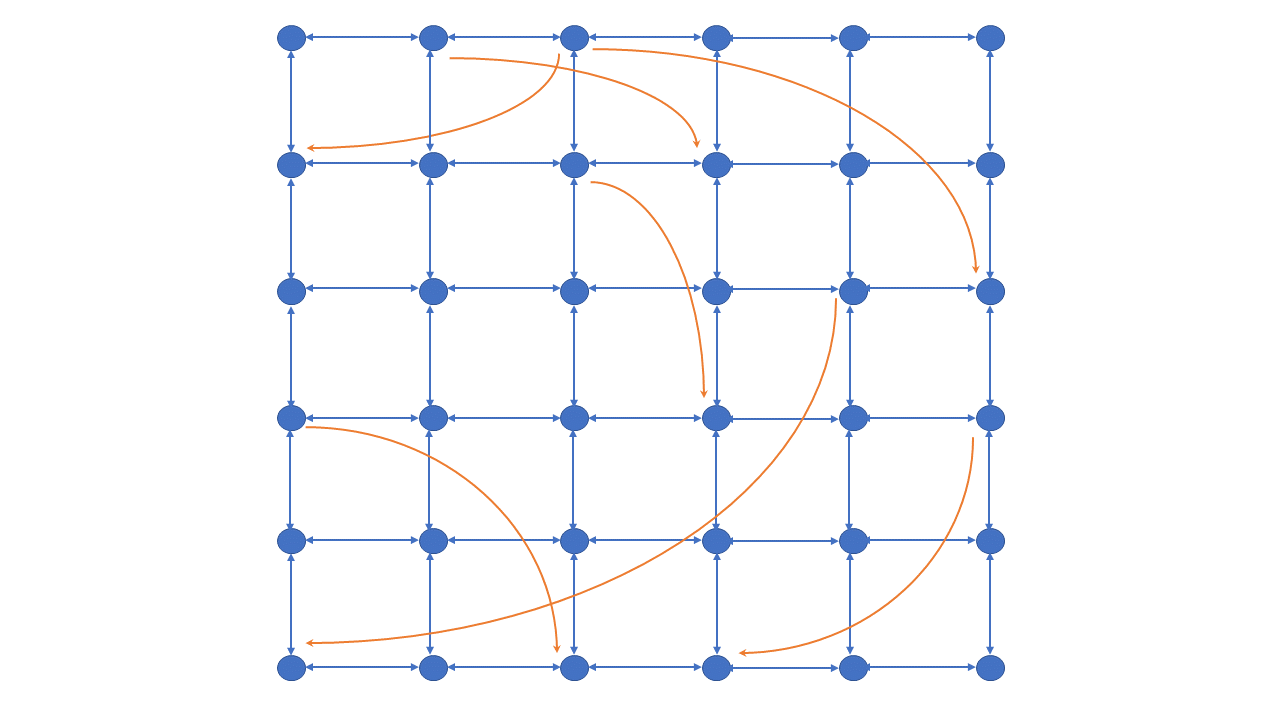

Figure 5.6: A two-dimensional grid with random shortcuts.

### 5.2.2 Centrality Measures

**Example 5.7.** In Table 5.13 we show the centrality measure scores for the
top-3 nodes in the karate club social network shown in Figure 5.5, noting
that the centrality scores have been normalised to add up to 1. It can be
verified that the spectral radius of this social network is 6.7257, and for
the computation of the potential gain we set α = 0.5/ρ(G), which gives
α = 0.0743.


In [23]:
# Import the ZKC graph:
G = nx.karate_club_graph()

# Degree dentrality
degree_centrality = nx.degree_centrality(G)

# Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G)

# Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)

# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Geometric potential mean
from numpy import linalg as LA
adj_karate = nx.to_pandas_adjacency(G)

n = np.array(adj_karate.shape) #size(adj_karate,1);
u = np.ones(n)
eig, eigenvectors = LA.eig(adj_karate)
alpha = 0.5 / max(abs(eig));

raw_pgain = adj_karate*((np.eye(n[0],1)-alpha*adj_karate) / u) #%potential gain
norm_pgain = pd.DataFrame(raw_pgain/sum(raw_pgain))

def printMeasure(measure, lim = 3):
    temp = []
    
    for _id in measure.keys():
        temp.append((measure[_id], _id))
    t = sorted(temp, reverse=True)
    for i in t[:lim]:
        print(i[1],"-", i[0])
    print("----------")
    
printMeasure(degree_centrality)
printMeasure(betweenness_centrality)
printMeasure(eigenvector_centrality)
printMeasure(closeness_centrality)

print(norm_pgain.max()[:3])

# find the index position of maximum
# values in every column
#maxValueIndex = norm_pgain.idxmax(axis=1)
 
#print("Maximum values of columns are at row index position :")
#print(maxValueIndex)

#i = 0
#for pg in norm_pgain.max()[:3]:  
 #   print(pg[i, maxValueIndex[i]])
  #  i+=1

33 - 0.5151515151515151
0 - 0.48484848484848486
32 - 0.36363636363636365
----------
0 - 0.43763528138528146
33 - 0.30407497594997596
32 - 0.145247113997114
----------
33 - 0.37337121301323506
0 - 0.35548349418519426
2 - 0.3171893899684447
----------
0 - 0.5689655172413793
2 - 0.559322033898305
33 - 0.55
----------
0    0.000000
1    0.006473
2    0.007885
dtype: float64


Table 5.13: Normalised centrality measures for the karate club data set,
with the top-3 scores for each measure, where id is the node identifier of a
member of the karate club and score is the centrality measure.

### 5.2.3 Power Laws and the 80-20 Rule


**Example 5.8**. We consider a data set containing the degree distribution of
inlinks for the web graph from a web crawl in 1999 of over 200 million nodes
and 1.5 billion links, performed by researchers from AltaVista, Compaq, and
IBM. The inlinks degree distribution for 1999 crawl is shown on the left-hand
side of Figure 5.7, while the log-log plot (see Section 3.7) of the data set,
after the application of logarithmic binning, is shown on the right-hand side
of the figure. The exponent of the power law distribution fitted with linear
regression to the log-log data results in α = 1.105, while the exponent fitted
to logarithmically binned data results in α = 0.492. On the other hand, the maximum likelihood estimate of the exponent of the resulting power law
distribution (see below) for the inlinks degree distribution is α = 0.500, with
the lower bound of the scale parameter of X set to xmin = 1.0.


          w
0  81060704
1  29622830
2  15047870
3   8320392
4   5594047


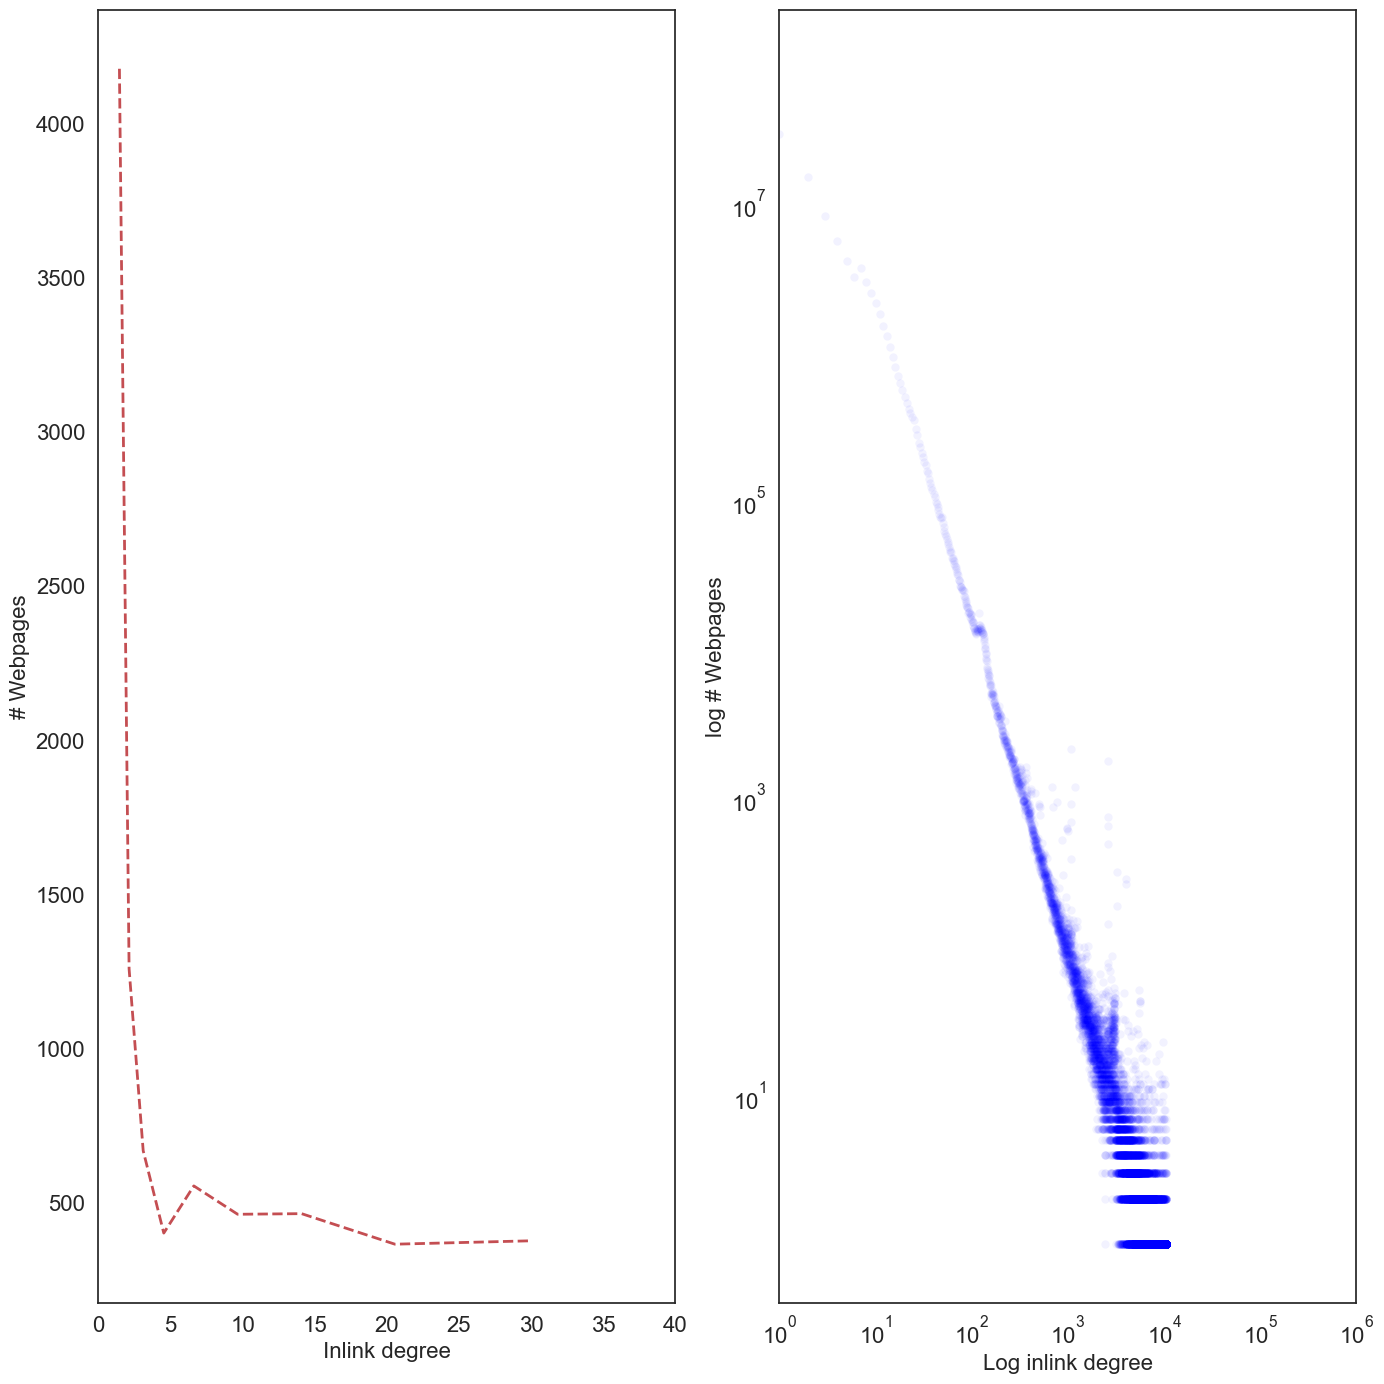

In [24]:
nbins = 10
df = pd.read_csv('./data/ibm1.txt') #fifa
print(df.head())


x = df.index 
y = df['w']

fig, ax = plt.subplots()
bins=np.logspace(start=np.log10(1), stop=np.log10(30), num=10)
(n, bins, part) = ax.hist(y, bins=bins)

#print(bins, n)


ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

ax1.plot(bins[1:], n, color='r', linestyle='--',linewidth=2)
ax1.set_xlabel('Inlink degree', fontsize=xlarge)
ax1.set_ylabel('# Webpages', fontsize=xlarge)
ax1.set_yscale('linear')
ax1.set_xscale('linear')

ax2.plot(df.index, df['w'], 'o', c='blue', alpha=0.05, markeredgecolor='none')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Log inlink degree', fontsize=xlarge)
ax2.set_ylabel('log # Webpages', fontsize=xlarge)

ax1.tick_params(axis='both', which='major', labelsize=xlarge)
ax2.tick_params(axis='both', which='major', labelsize=xlarge)

ax1.set_xlim([0, 40])
ax2.set_xlim([1, 10**6])

plt.tight_layout()

Figure 5.7: The inlinks degree distribution plot (left) and the log-log plot
(right) of the 1999 crawl data set.


**Example 5.9**. A Pareto chart is a bar chart with the bars sorted in descending order that also a line that shows the corresponding cumulative
distribution. In particular, the Pareto chart shows the largest bars that
contain, say, the 95% of the cumulative distribution. In Figure 5.8 we show
the Pareto chart for the 1999 web crawl data set with a horizontal broken
line at the 95% value of the cumulative distribution of inlinks.


          w    cumperc
0  81060704  45.855996
1  29622830  62.613615
2  15047870  71.126187
3   8320392  75.833028
4   5594047  78.997578
0         45.855996
1         62.613615
2         71.126187
3         75.833028
4         78.997578
            ...    
10549     99.999998
10550     99.999998
10551     99.999999
10552     99.999999
10553    100.000000
Name: cumperc, Length: 10554, dtype: float64


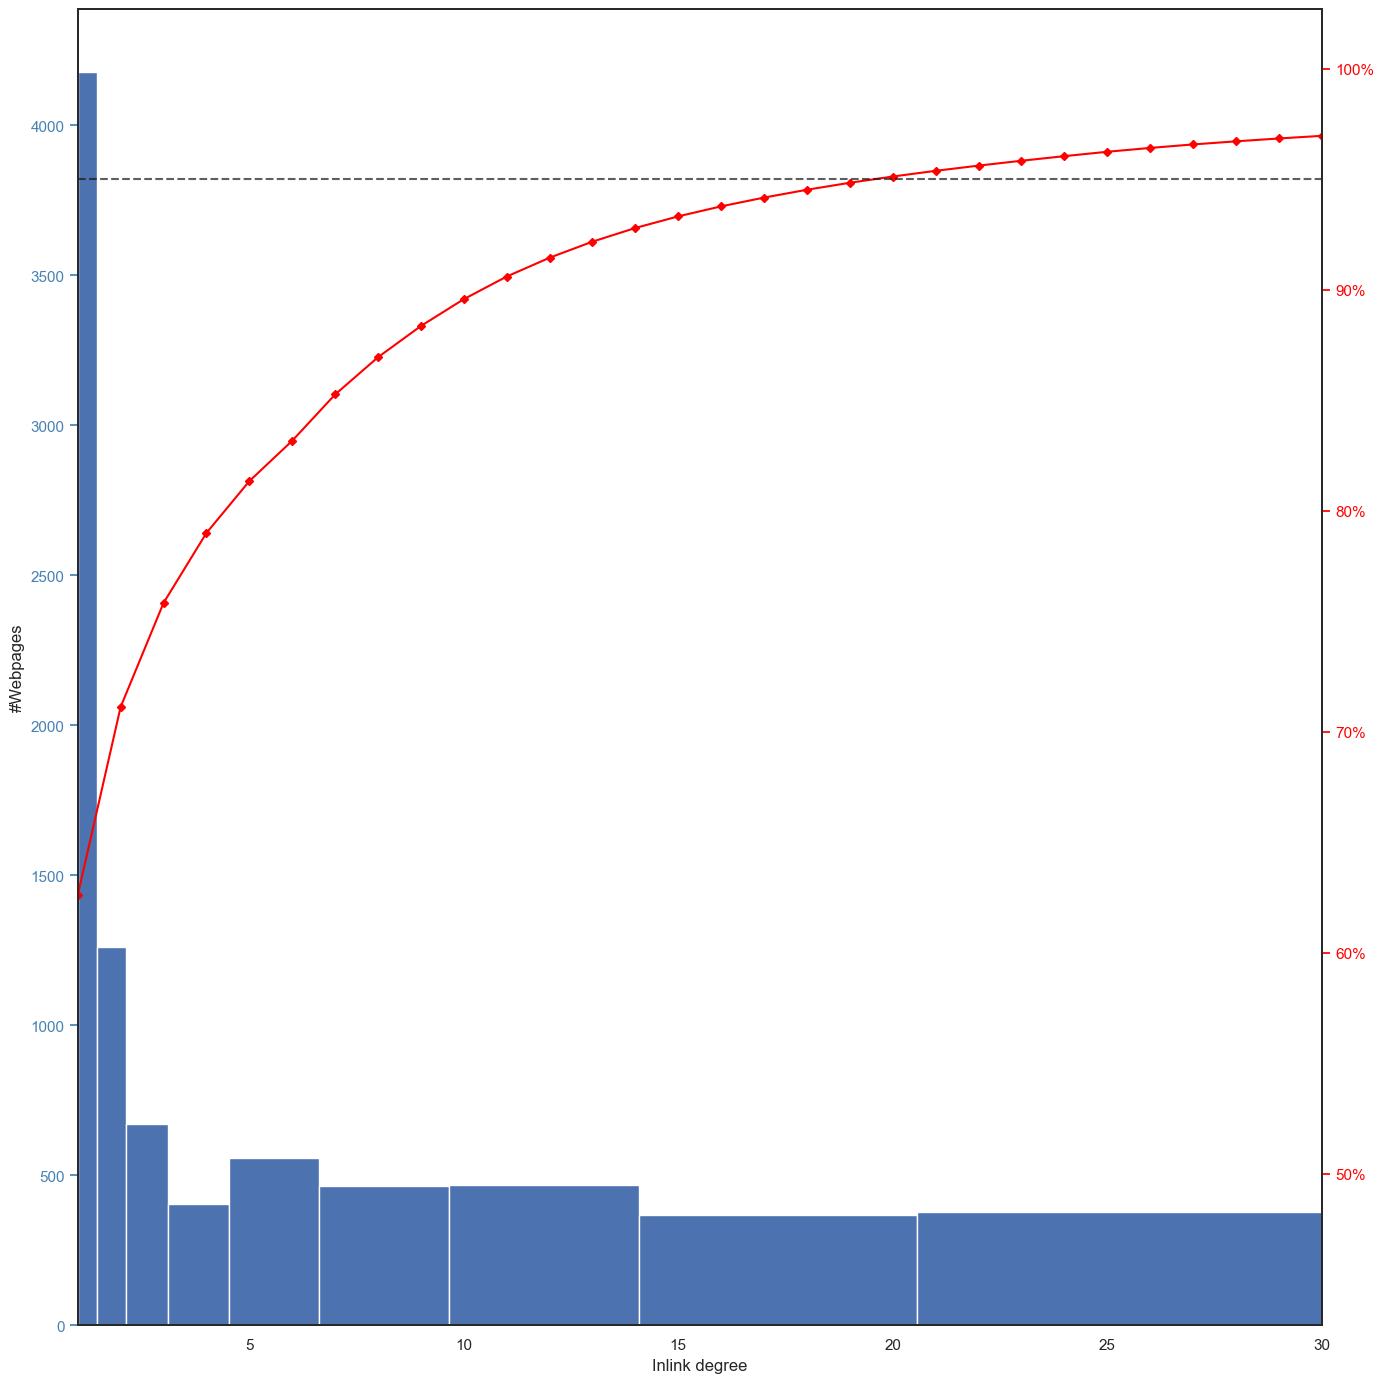

In [25]:
# Carry out logarithmic binning on the data set and plot it on a log-log scale.!
nbins = 10
df = pd.read_csv('./data/ibm1.txt') #fifa

#add column to display cumulative percentage
df['cumperc'] = df['w'].cumsum()/df['w'].sum()*100
print(df.head())

#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 4

x = df.index 
y = df['w']

#create basic bar plot
fig, ax = plt.subplots()
ax.hist(y, bins=np.logspace(start=np.log10(1), stop=np.log10(30), num=10))

#add cumulative percentage line to plot
ax2 = ax.twinx()
print(df['cumperc'])
ax2.plot(df.index, df['cumperc'], color=color2, marker="D", ms=line_size)

ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.axhline(95, ls="--", color="k", alpha=0.7)

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)
ax.set_ylabel("#Webpages")
ax.set_xlabel("Inlink degree")

ax.set_xlim([1, 30])
plt.tight_layout()

Figure 5.8: A Pareto chart for the 1999 crawl data set.


### 5.2.4 SIS and SIR Models for the Spread of Disease

**Example 5.10**. In Figure 5.9 we demonstrate the SIS model based on a
365 day period, recorded on a daily basis, recorded on a daily basis, with a
population size of N = 58, 500. Its model parameters include an initial group
I(0) = 2 of infected individuals, a transmission rate per day of β = 0.259 and
a recovery rate per day of γ = 0.045. Thus, in this case R0 = 0.259/0.045 =
5.756. Table 5.14 shows the progression of the disease for the SIS model
over the first 100 days.

In [26]:
Header = " day, Susceptible, infectious,   formula,     error,    % infected "
e=2.7182818284  # Euler's number (approx)


def f(y, t, parm):             # returns the derrivative of f(t) (y)
    I = y[0]                   # get the current value of y
    plam,gammar, Npop = parm             # get the parameter
    derivative = [plam*I*(1-I/Npop)] -gammar*I     # calculate the derrivative
    return derivative

plam = 0.2587      # growth rate at start (infections per day per infector)
gammar = 0.045     # the daily probability of recovery from the virus
Npop = 58500       # Total "population" (Hubei in thousands)
I0 = 1.619         # Initial number of infected (hubei in thousdands)
Finaltime = 365.    # The sumulation goes from time = 0 to here (in days)
Increment = 1.0    # How often you want the result retured (in days)

# Set up for the simulation 
parm = [plam,gammar, Npop]   #ODE solver wants a list of Parameters
y0 = [I0]       #ODE also wants a list of initial values

# Make an array of the times at which we want a solution
times = np.arange(0.0, Finaltime, Increment)

Solutions = odeint(f, y0, times, args=(parm,))

lambdastar = plam - gammar
Nstar=Npop*lambdastar/plam
temp1 = []
for i in range(len(times)): # printout and compare with actual solution
    t = times[i]
    I = Solutions[i,0]
    S = Npop - I
    val = Nstar/(1+(Nstar-I0)/I0 * e**(-1.0*lambdastar*t) ) # analytic solution
    error = (val-I)/val
    pinfect = I/Npop*100.0

    temp1.append([t, S, I, I*(pinfect/100)])
    
    #if int(times[i]) % 20 == 0: 
    #    print([t, S, I, I*(pinfect/100)])
df1 = pd.DataFrame(temp1, columns=['T', 'Susceptible', 'Infectious', 'Infected'])
print(df1.head(6))

     T   Susceptible  Infectious  Infected
0  0.0  58498.381000    1.619000  0.000045
1  1.0  58497.995287    2.004713  0.000069
2  2.0  58497.517687    2.482313  0.000105
3  3.0  58496.926311    3.073689  0.000161
4  4.0  58496.194058    3.805942  0.000248
5  5.0  58495.287377    4.712623  0.000380


Table 5.14: A sample of the SIS model output showing the number of
susceptible S(t), and the number of infected individuals I(t), both at time
t.

In [27]:
# SIR model
from scipy.integrate import odeint

N = 58500
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1.619, 0.4
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta = 0.2 
gamma = 1./10 

#print(beta, gamma)
# A grid of time points (in days)
t = np.linspace(0, 365, 365)


# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
#print("S,I,R",y0)

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T
#print(S)
temp2 = []
for i in range(len(S)):
    temp2.append([t[i],S[i], I[i], R[i]])
    # Print output every 20 rows
    #if int(t[i]) % 20 == 0: 
    #    print([t[i],S[i], I[i], R[i]])
    
    
df2 = pd.DataFrame(temp2, columns=["T", "Susceptible", "Infected", "Recovered"])
print(df2.head(5))

          T   Susceptible  Infected  Recovered
0  0.000000  58497.981000  1.619000   0.400000
1  1.002747  58497.639487  1.789750   0.570763
2  2.005495  58497.261959  1.978506   0.759535
3  3.008242  58496.844618  2.187166   0.968216
4  4.010989  58496.383267  2.417828   1.198905


Table 5.15: A sample of the SIR model output for each of the parameters
A sample of the SIR model output showing the number of susceptible S(t),
the number of infected I(t), and the number of recovered individuals R(t),
all at time t.

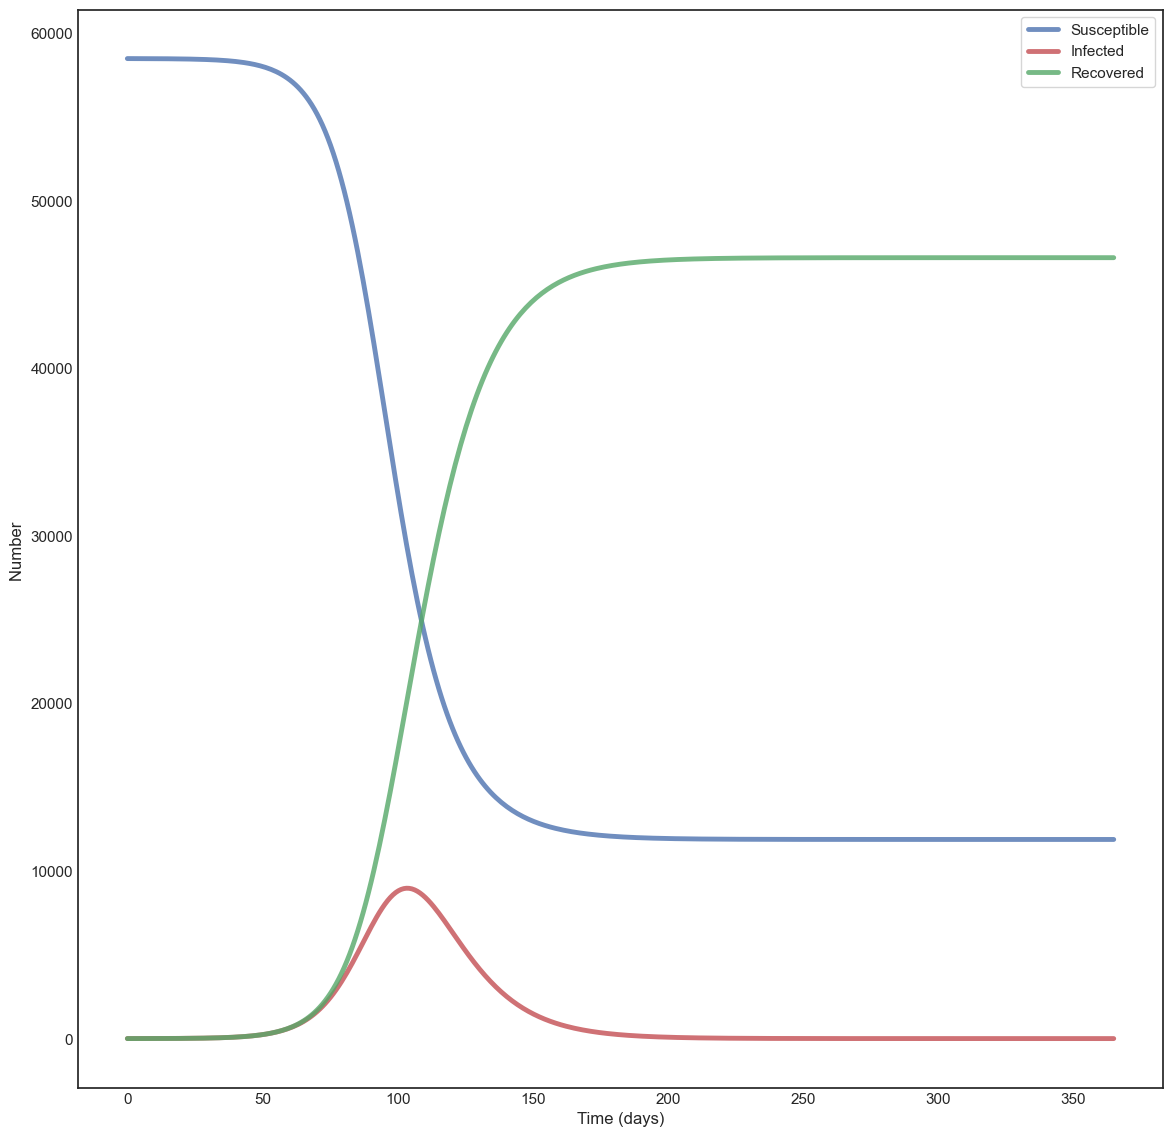

In [28]:
# Plot the SIS data on three separate curves for S(t), I(t) and R(t)
df2 = pd.DataFrame(temp2, columns=["T", "Susceptible", "Infected", "Recovered"])

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S, 'b', alpha=0.8, lw=3.5, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.8, lw=3.5, label='Infected')
ax.plot(t, R, 'g', alpha=0.8, lw=3.5, label='Recovered')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number ')

ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)

legend = ax.legend()

Figure 5.9: A plot showing the dynamics of the SIS model, where the x-axis
is time in days and the y-axis is the number of individuals in a compartment;
blue=susceptible and red=infected.

Text(0.5, 0, 'Time (days)')

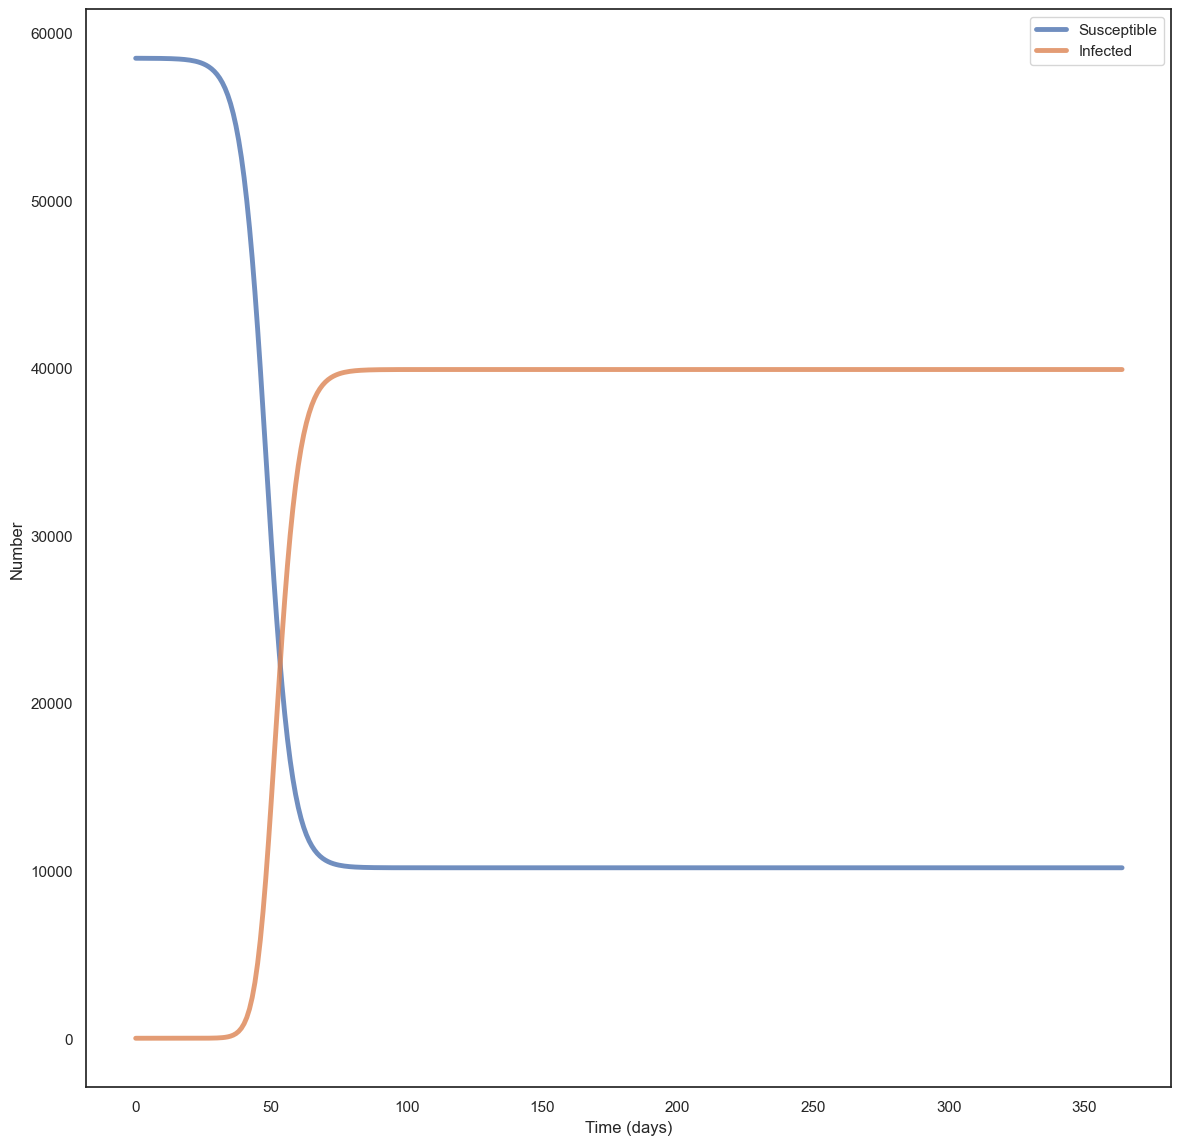

In [29]:
# Plot SIR model
ax = df1[['Susceptible', 'Infected']].plot(alpha=0.8, lw=3.5)
ax.set_ylabel('Number')
ax.set_xlabel('Time (days)')

Figure 5.10: A plot showing the dynamics of the SIR model, where the
x-axis is time in days and the y-axis is the number of individuals in a compartment; blue=susceptible, red=infected and green=recovered.

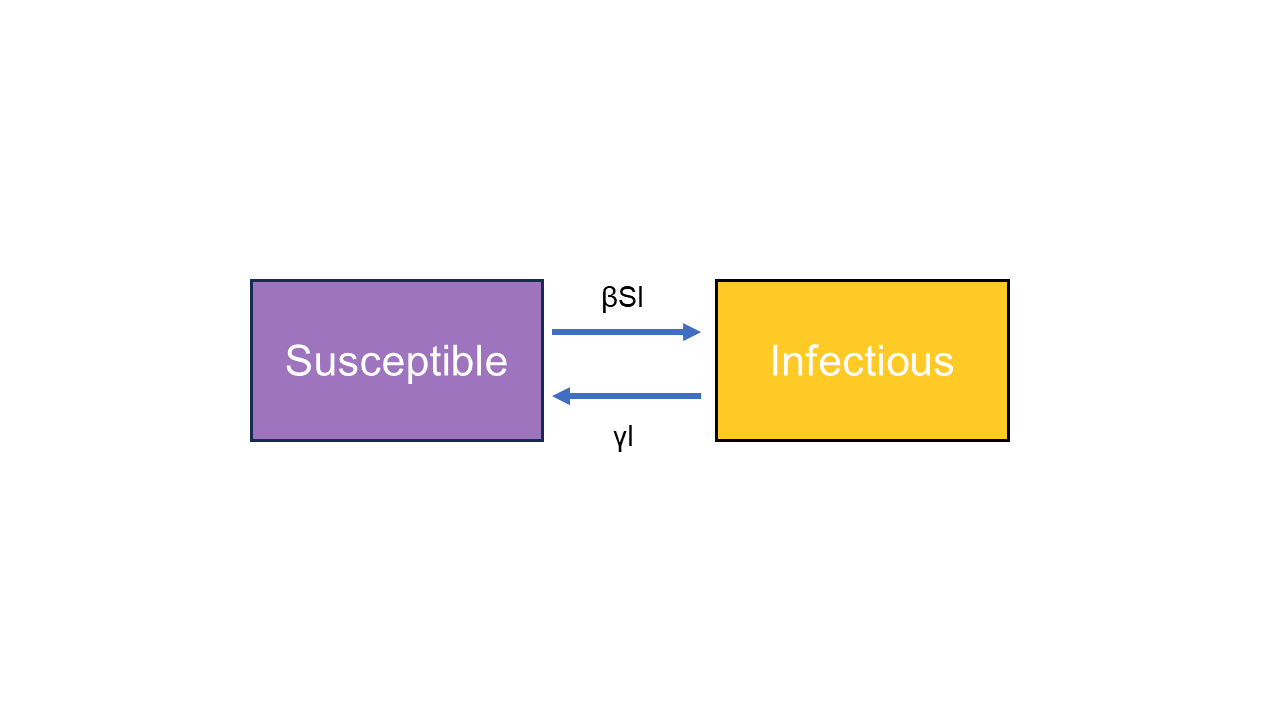

Figure 5.11: Transfer diagram for the SIS compartmental model.

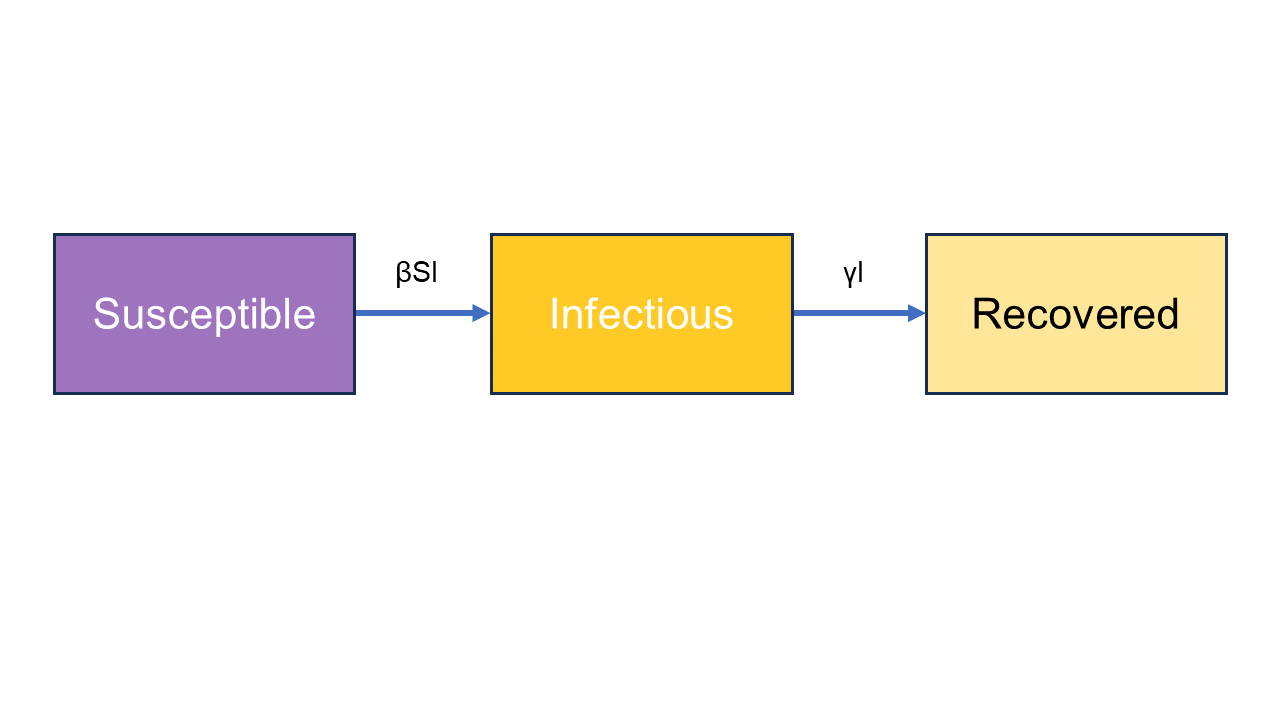

Figure 5.12: Transfer diagram for the SIR compartmental model.

## 5.3 Sentiment Analysis, Named Entity Recognition and Word Embeddings

### 5.3.1 Sentiment Analysis


**Example 5.11**. We apply sentiment analysis to a movie review data set,
containing reviews collated from three different sources including IMDB,
Amazon and Yelp, where each collection of reviews is composed of 500 positive and 500 negative sentences, labelled as 0 or 1, respectively. We apply
sentiment analysis to a sample of 1,000 reviews using naive Bayes classifier
as the machine learning algorithm; the model was trained without a lexicon.
The test set is labelled by the classifer with sentiment values ranging from
-1 to 1, where -1 is negative, 0 is neutral, and 1 is positive sentiment. A
sample of the sentiment output from the classifier is shown in Table 5.16.


In [30]:
sia = SentimentIntensityAnalyzer()

fileinput = "./data/imdb_labelled.txt"

temp = []
for row in open(fileinput).readlines():
    sent, score = row.split('\t')
    score = score.replace("\n","")
    temp.append([score, sent])
    
df = pd.DataFrame(temp, columns=['Score', 'Sentence'])

print(df.head(5))

  Score                                           Sentence
0     0  A very, very, very slow-moving, aimless movie ...
1     0  Not sure who was more lost - the flat characte...
2     0  Attempting artiness with black & white and cle...
3     0       Very little music or anything to speak of.  
4     1  The best scene in the movie was when Gerardo i...


Table 5.16: A sample of sentences from the data set with the learned
sentiment in the first column, and the text representing the sentence in the
second column.

### 5.3.2 Named Entity Recognition


**Example 5.12**. We make use of a data set, known as the CoNLL-2002
(Conference on Computational Natural Language Learning) named entity
data set, which consists of text documents covering news topics with labels
(also known as tags in his context) for each word, encoding whether the word
is a type of named entity. Words tagged with O (denoting the Other class),
are not considered to be named entities. The data set provides four types
of named entities: (i) Per (denoting the Person class), (ii) Org (denoting the organisation class), (iii) Loc (denoting the location class) and (iv) Misc
(denoting miscellaneous names), which are those that have been identified
as named entities, but are not part of the labelling schema. A sample of
sentences from the test data set together with their annotations, is shown
in Table 5.17; the model was trained and tested on the CoNLL-2002 data
set, with a 67-33 split.


In [31]:
nltk.corpus.conll2002.fileids()

train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

train_sents[0]

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

sent2features(train_sents[0])[0]

X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]


crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

labels = list(crf.classes_)
labels.remove('O')
labels

y_pred = crf.predict(X_test)

print(train_sents[0])
print(y_pred[0])

[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]
['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']


Table 5.17: A sample of sentences from the CONLL-2002 data set, annotated with their named entities

### 5.3.3 Word Embeddings


**Example 5.13**. Here we explore word embeddings generated by word2vec
from a corpus containing 100 billion words from a large snapshot of the
Google News data set. Table 5.18 shows ten words related to king together
with their cosine similarity scores. A visualisation of this small sample of
word embeddings in two-dimensional vector space, where the algorithm that
created the visualisation strives to maintain the cosine similarity between
the embeddings, is shown in Figure 5.15.

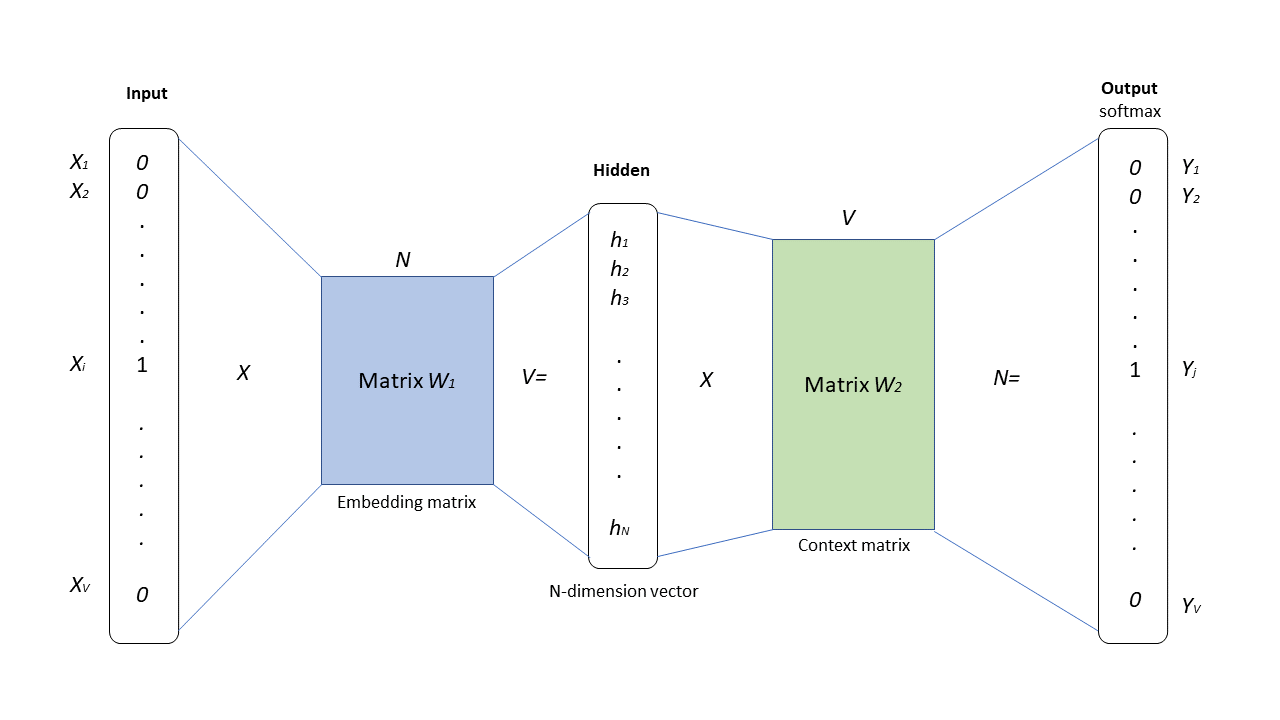

Figure 5.13: The skip-gram word2vec neural network architecture.


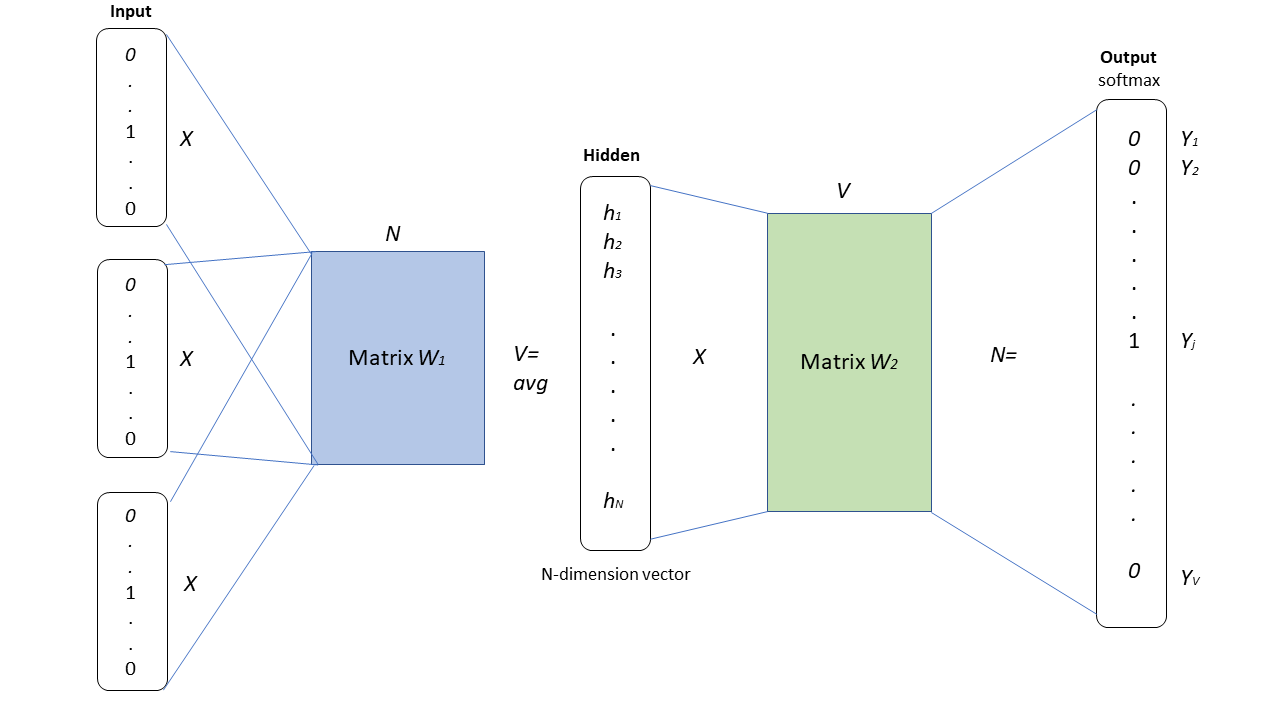

In [32]:
## Note we use a smaller word embedding in this example, for the full stat

Figure 5.14: The CBOW word2vec neural network architecture.

In [33]:
def find_similar_word(embedes):
  temp = []
  wordlist = sorted(embed_dict.keys(), key=lambda word: spatial.distance.cosine(embed_dict[word], embedes))[:10]
  for word in sorted(embed_dict.keys()):  
      if word in wordlist:
          score = spatial.distance.cosine(embed_dict[word], embedes)          
          temp.append([score, word])
      else: continue
  return sorted(temp, reverse=True)

embed_dict = {}

with open('./data/glove6B200d.txt','rb') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    embed_dict[word]=vector

for score, word in find_similar_word(embed_dict[b'king']):
    print("KING", word, score)


KING b'crown' 0.420352041721344
KING b'iii' 0.4162874221801758
KING b'reign' 0.40883201360702515
KING b'throne' 0.3925294876098633
KING b'ii' 0.3853556513786316
KING b'monarch' 0.3775649070739746
KING b'kingdom' 0.36967897415161133
KING b'queen' 0.3334802985191345
KING b'prince' 0.31454330682754517
KING b'king' 0


Table 5.18: Ten words similar to king, with their cosine similarity scores.

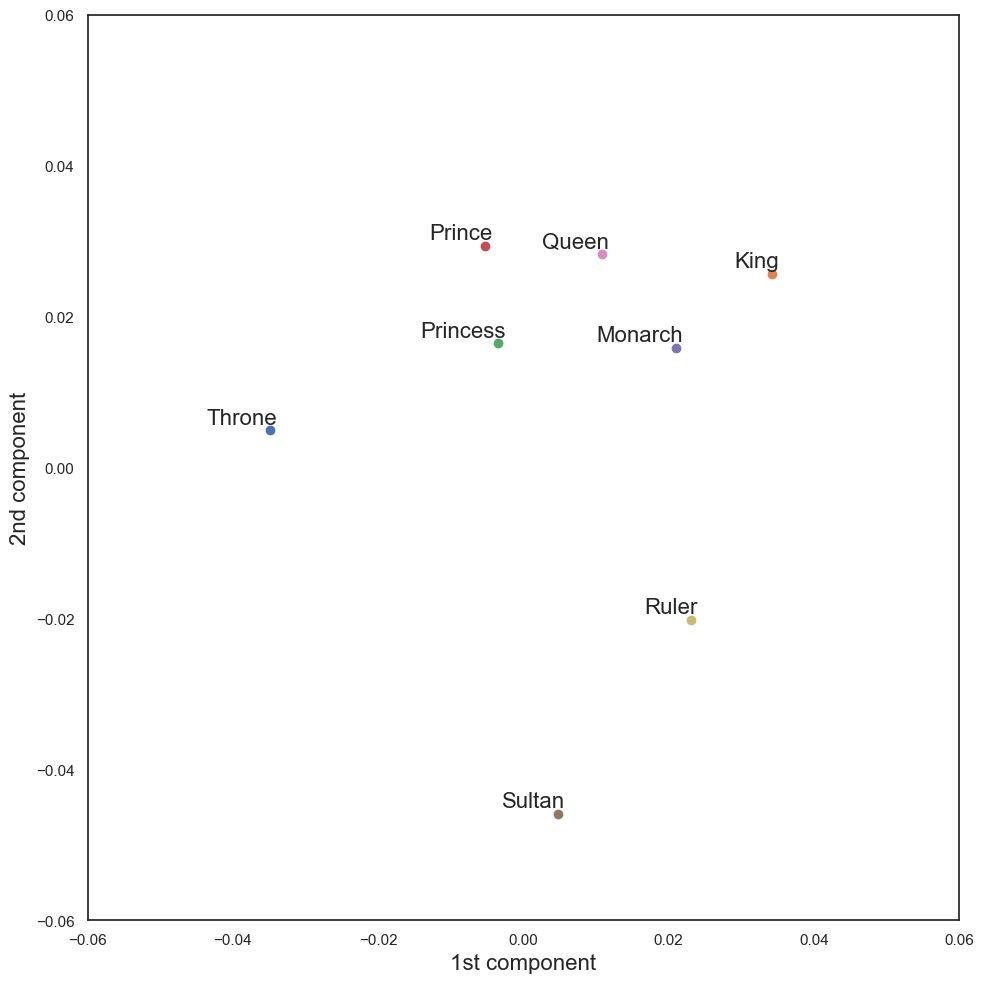

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Define the corpus
f = open("./data/embedding_corpus.txt", "rb")
data = f.read()
f.close()

corpus = data.decode("utf8").lower().split(" ")

# Convert the corpus to a sequence of integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

# Define the parameters
vocab_size = len(tokenizer.word_index) + 1
embedding_size = 10
window_size = 2

# Generate the context-target pairs
contexts = []
targets = []
for sequence in sequences:
    for i in range(window_size, len(sequence) - window_size):
        context = sequence[i - window_size:i] + sequence[i + 1: i + window_size + 1]
        target = sequence[i]
        #print(target)
        contexts.append(context)
        targets.append(target)

# Convert the contexts and targets to numpy arrays
X = np.array(contexts)

# Define the CBOW model
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
					output_dim=embedding_size,
					input_length=2*window_size))
model.add(Lambda(lambda x: tf.reduce_mean(x, axis=1)))
model.add(Dense(units=vocab_size, activation='softmax'))
model.save_weights('cbow_weights.h5')


# Load the pre-trained weights
model.load_weights('cbow_weights.h5')

# Get the word embeddings
embeddings = model.get_weights()[0]

keywords = ['king', 'queen', 'monarch', 'prince', 'sultan','ruler', 'princess', 'throne', 'crown']#, 'kings']


# Perform PCA to reduce the dimensionality
# of the embeddings
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

fsize = 16
offsetX = 0
offsetY = 0

# Visualize the embeddings
plt.figure(figsize=(10, 10))
for i, word in enumerate(tokenizer.word_index.keys()):
    if word not in keywords: continue
    #print(word)
    x, y = reduced_embeddings[i]
   # if word == 'prince':
        #fsize = 18
    #    offsetY = 0.12

    #plt.text(x+offsetX, y+offsetY, word.replace("_", " "), fontsize=fsize)
    plt.xlim(-0.06, 0.06)
    plt.ylim(-0.06, 0.06)
    plt.xlabel("1st component", fontsize=fsize)
    plt.ylabel("2nd component", fontsize=fsize)
    plt.scatter(x, y)
    plt.annotate(word.title(), xy=(x+offsetX, y+offsetY), xytext=(5, 2),
				textcoords='offset points',
                ha='right', va='bottom', fontsize=fsize)

plt.tight_layout()   

Figure 5.15: A visualisation of a small sample of word embeddings in twodimensional vector space, which strives to maintain the cosine similarity
between the embeddings.